In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os


######################################################################################################### 
####                                            Arguments                                           #####
######################################################################################################### 

## account for the folder structure 
import sys
sys.path.append(os.path.abspath("../scr"))


import wandb 

In [3]:
# Replace argparse with a dictionary
args = {

    "seed": 42, 

    'dataset_transform': [],  # Example list of transformations
    'numbers_list': [1,2,3,4,5],  # List of integers for class selection
    'N': 20,  # Number of distinct training images per class
    'supervision_label_val': 10,  # An integer value for supervision

    # -----graph-----
    'num_internal_nodes': 1500,  # Number of internal nodes
    'graph_type': 'fully_connected',  # fully_connected_w_self  |  Type of graph fully_connected

    'remove_sens_2_sens': False, 
    'remove_sens_2_sup': False, 

    # -----model-----
    "normalize_msg": False, 
    'model_type': 'IPC',  # Predictive model type
    'weight_init': 0.001,  # Weight initialization
    'T': 5,  # Number of iterations for gradient descent
    'lr_values': 0.1,  # Learning rate for values
    'lr_weights': 0.00001,  # Learning rate for weights
    'activation_func': 'swish',  # Activation function

    # -----learning-----
    'epochs': 5,  # Number of epochs
    'batch_size': 1,  # Batch size
    'seed': 42,  # Random seed
    'optimizer': False,  # Optimizer, can be True with a float value

    # -----logging-----
    'use_wandb': 'disabled',  # Wandb mode
}

# Access the arguments just like you would with argparse
print(args['dataset_transform'])  # Example of accessing an argument


[]


In [4]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)


# Create an object from the dictionary
args = Args(**args)


In [5]:



# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"

    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"], 
        # "params_general": {
        #     "remove_sens_2_sens": args.remove_sens_2_sens,  # Set from command line
        #     "remove_sens_2_sup": args.remove_sens_2_sup,    # Set from command line
        #     },
        },  
    "seed": args.seed,   
}

print("zzz", args.remove_sens_2_sens, args.remove_sens_2_sup)
graph_params["graph_type"]["params"]["remove_sens_2_sens"] = args.remove_sens_2_sens  
graph_params["graph_type"]["params"]["remove_sens_2_sup"]  = args.remove_sens_2_sup 


if graph_params["graph_type"]["name"] == "stochastic_block":
    
    # override internal nodes if doing clustering
    graph_params["internal_nodes"] = (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

from dataset import CustomGraphDataset

# Initialize the GraphBuilder
custom_dataset_train = CustomGraphDataset(graph_params, **dataset_params)

dataset_params["batch_size"] = args.batch_size
dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

print("Device \t\t\t:", device)
print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


from helper.plot import plot_adj_matrix

single_graph = custom_dataset_train.edge_index


print("--------------Init DataLoader --------------------")
train_loader = DataLoader(custom_dataset_train, 
                          batch_size=dataset_params["batch_size"], 
                          shuffle=True, 
                          generator=generator_seed,
                          num_workers=1
                          )




NUM_SENSORY = 28*28  # 10

## TODO: FIX HOW TO DO THIS 
#### ---------------------------------------------------------------------------------------------------------------
# sensory_indices    = range(NUM_SENSORY)
# internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
# num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
# supervision_indices = None

# if dataset_params["supervised_learning"]:
#     label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
#     supervision_indices = label_indices
#     num_vertices += 10

# print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
# print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
# print("num_vertices \t\t:", num_vertices)

# if dataset_params["supervised_learning"]:
#   assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
# else:
#   assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"
#### ---------------------------------------------------------------------------------------------------------------

num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices



print(train_loader.batch_size)
for batch, clean_image in train_loader:
    
    values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
    x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
    print("edge_index", edge_index.shape)

    print(batch.x[:, 0].shape)
    print(custom_dataset_train.edge_index.shape)
    

    full_batch = edge_index

    break




######################################################################################################### 
####                                            VALIDATION                                          #####
######################################################################################################### 
 
# from helper.validate_MP import validate_messagePassing
# validate_messagePassing()

######################################################################################################### 
####                                            FIND OPTIMAL LR                                     #####
######################################################################################################### 
""" 
SKIPPING FOR NOW, see local  
"""



######################################################################################################### 
####                                              Model  (setup)                                    #####
######################################################################################################### 

# lr_gamma, lr_alpha =  (0.1 ,  0.0001)
# lr_gamma, lr_alpha =  (0.1, 0.00001)


model_params = {
    
    'num_vertices': num_vertices,
    'sensory_indices': (sensory_indices), 
    'internal_indices': (internal_indices), 
    "supervised_learning": (supervision_indices),

    "lr_params": (args.lr_values, args.lr_weights),
    #   (args.lr_gamma, args.lr_alpha), 
    "T": args.T,
    "graph_structure": custom_dataset_train.edge_index_tensor, 
    "batch_size": train_loader.batch_size, 
    'edge_type': custom_dataset_train.edge_type, 

 
    "use_learning_optimizer": args.optimizer if not args.optimizer  else [args.optimizer],    # False or [0], [(weight_decay=)]
    
    # "weight_init": "uniform",   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "weight_init": args.weight_init,   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "activation": args.activation_func,  
    "clamping": None , # (0, torch.inf) or 'None' 

    "normalize_msg": args.normalize_msg,
 }

# 

learning_params = model_params.copy()
learning_params['sensory_indices'] = list(learning_params['sensory_indices'])
learning_params['internal_indices'] = list(learning_params['internal_indices'])
learning_params['supervised_learning'] = list(learning_params['supervised_learning'])
# learning_params['transform'] = transform.to_dict()["transform"]
learning_params['dataset_transform'] = args.dataset_transform

learning_params['graph_structure'] = (learning_params['graph_structure']).cpu().numpy().tolist()

model_params_name = f"num_internal_nodes_{args.num_internal_nodes}_T_{args.T}_lr_weights_{args.lr_weights}_lr_values_{args.lr_values}_batch_size_{train_loader.batch_size}"

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    
    raise TypeError('Unknown type:', type(obj))

# combi of learning params and dataset params
params_dict = {**dataset_params, **learning_params}


import json

from datetime import datetime




save_model_params = False

GRAPH_TYPE = graph_params["graph_type"]["name"]    #"fully_connected"
# GRAPH_TYPE = "test"    #"fully_connected"

date_hour = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

model_dir = f"trained_models/test/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"
# model_dir = f"trained_models/{args.model_type.lower()}/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"

# Define the directory path
print("Saving model, params, graph_structure to :", model_dir)

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# For saving, validation, re-creation 
os.makedirs(os.path.join(model_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "parameter_info"), exist_ok=True)

# For testing the model
os.makedirs(os.path.join(model_dir, "eval"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/generation"), exist_ok=True)
# os.makedirs(os.path.join(model_dir, "reconstruction"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/classification"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/denoise"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/occlusion"), exist_ok=True)

# Monitor during training
os.makedirs(os.path.join(model_dir, "energy"), exist_ok=True)

plot_adj_matrix(single_graph, model_dir, 
                node_types=(sensory_indices, internal_indices, supervision_indices))
plot_adj_matrix(full_batch, model_dir, node_types=None)





Using device: cuda
Seed used 42
Device name:  NVIDIA GeForce MX130
zzz False False
Supervised learning
Taking first n=20 digits from each class
graph_params {'internal_nodes': 1500, 'supervised_learning': True, 'graph_type': {'name': 'fully_connected', 'params': {'remove_sens_2_sens': False, 'remove_sens_2_sup': False}}, 'seed': 42}
Setting seed: 42
--------Init base indices for sensory, internal, supervision nodes--------
--------Updating base indices for sensory, internal, supervision nodes--------
{'remove_sens_2_sens': False, 'remove_sens_2_sup': False}
Creating graph structure for fully_connected
graph created
self.edge_index torch.Size([2, 5260142])
---------save_graph_to_file--------------------
Graph data saved in graphs/fully_connected/_normal/42
-----Done-----
2294
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,

In [6]:
import wandb 

run = wandb.init(
    mode=args.use_wandb,
    # entity="Erencan Tatar", 
    project=f"PredCod",
    name=f"T_{args.T}_lr_value_{args.lr_values}_lr_weights_{args.lr_weights}_",
    id=f"{model_params_name}_{date_hour}",
    # tags= 
    dir=model_dir,
    

    # tags=["param_search", str(model_params["weight_init"]), model_params["activation"],  *learning_params['dataset_transform']], 
    # Track hyperparameters and run metadata
    config={
        "supervised_learning": (graph_params["supervised_learning"]),

        "lr_params": (args.lr_values, args.lr_weights), 
        "T": args.T,

        "graph_structure": args.graph_type, 
        "model_type": args.model_type.lower(), 
        # "graph_structure": custom_dataset_train.edge_index_tensor, 
        # "include_self_connections": dataset_params['include_self_connections'],
        "batch_size": train_loader.batch_size, 
        "use_learning_optimizer": model_params["use_learning_optimizer"],    # False or [0], [(weight_decay=)]
        "weight_init":  model_params["weight_init"],   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
        "activation":  model_params["activation"],  
        "clamping": model_params["clamping"], # (0, torch.inf) or 'None' 

        "numbers_list":         dataset_params["numbers_list"],    
        "N":                    dataset_params['N'],     # taking the first n instances of each digit or use "all"

        "transform": learning_params['dataset_transform'],
    },
)

# Contains graph edge matrix and other parameters so quite big to open.
if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_full.txt", 'w') as file:
        json.dump(params_dict, file, default=default)
    print('Done')

# Store the exact command-line arguments in a text file
import sys
command = ' '.join(sys.argv)
with open(model_dir +'parameter_info/command_log.txt', 'w') as f:
    f.write(command)

with open('trained_models/current_running.txt', 'w') as f:
    f.write(model_dir)

# Save the (small) dictionary to a text file
params_dict_small = {}
keys_to_copy = ['supervised_learning', 'numbers_list', 'NUM_INTERNAL_NODES',  
                'N',  'batch_size','use_learning_optimizer', 'weight_init', 'activation', ]
# copy value from params_dict to params_dict_small
for key in keys_to_copy:
    params_dict_small[key] = params_dict[key]

if "dataset_transform" in params_dict:
    params_dict_small["dataset_transform"] = params_dict["dataset_transform"]

if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_small.txt", 'w') as file:
        json.dump(params_dict_small, file, default=default)
    print('Done')

print(f"Using batch size of \t: {train_loader.batch_size}")
print("Device \t\t\t:",          device)
print("Model type \t\t:", args.model_type.lower())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using batch size of 	: 1
Device 			: cuda
Model type 		: ipc


In [7]:
batch

DataBatch(x=[2294, 3, 1], edge_index=[2, 5260142], edge_attr=[5260142], y=[1], batch=[2294], ptr=[2])

In [8]:
# model_params["normalize_msg"] = True 
# model_params["weight_init"] = 0.001
# model_params["weight_init"] = "normal"
# model_params["use_learning_optimizer"] = [0.1]
# model_params["use_learning_optimizer"] = False



In [9]:
from models.PC import PCGNN
from models.IPC import IPCGNN
# args.model_type = "ipc"
# args.model_type = "pc"


In [10]:
model = None 

if args.model_type.lower() == "pc":
        

    model = PCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)

    print("-----------Loading PC model-----------")

if args.model_type.lower() == "ipc":
        

    model = IPCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)
    print("-----------Loading IPC model-----------")

# Magic
# wandb.watch(model, 
#             log="all",   # (str) One of "gradients", "parameters", "all", or None
#             log_freq=10)


from helper.plot import plot_model_weights


save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch0.png')
# plot_model_weights(model, save_path)



######################################################################################################### 
####                                              Model  (training)                                 #####
######################################################################################################### 

model.pc_conv1.set_mode("training")

------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
----- using grokfast: False
----- using use_bias: False
normalize_msg False
-------------initialize--------------
-------------Activation func set to swish--------------
------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
----- using grokfast: False
----- using use_bias: False
normalize_msg False
-------------initialize--------------
-------------Activation func set to swish--------------
-----------Loading IPC model-----------
vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode training--------------
-------------task None--------------


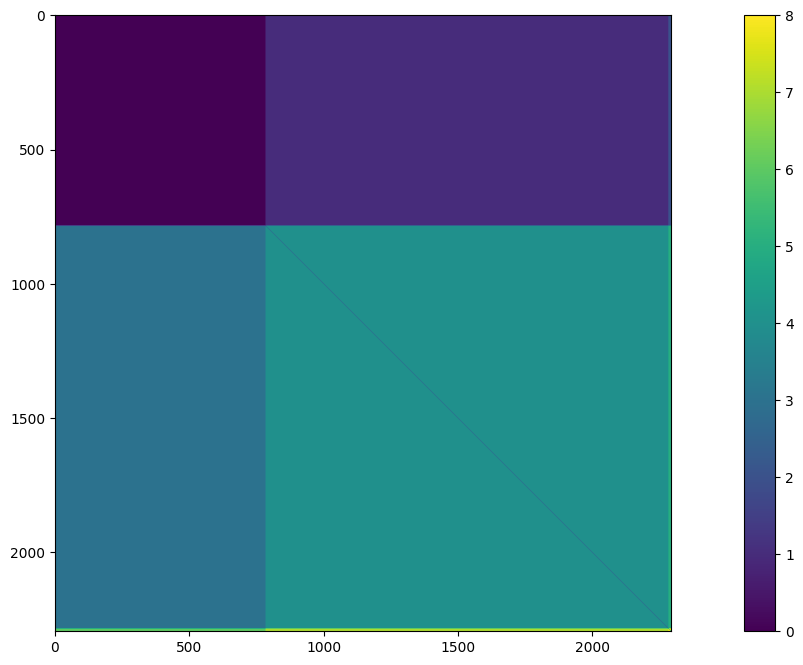

In [11]:
# Extract the edge indices and weights
import scipy.sparse as sp


conn_types = custom_dataset_train.edge_type
edge_index = custom_dataset_train.edge_index

# Create a sparse matrix using the edge indices and weights
W_sparse = sp.coo_matrix((conn_types, (edge_index[0], edge_index[1])), shape=(model.pc_conv1.num_vertices, model.pc_conv1.num_vertices))

# Convert to dense for detailed visualization (if the graph is not too large)
W = W_sparse.toarray()

fig, axs = plt.subplots(figsize=(19,8))
plt.imshow(W)
plt.colorbar()
plt.show()

In [12]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:2000].reshape(40,50))
    plt.show()

In [13]:
# assert 1 == 2 

In [14]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [15]:
from helper.plot import plot_energy_during_training

import time 
torch.cuda.empty_cache()

print(model)      

model = model.to(device)
# assert train_loader.batch_size == 1
print(len(train_loader))
print("Starting training")


# Initialize early stopping and history
earlystop = False
history = {
    "internal_energy_per_epoch": [],
    "sensory_energy_per_epoch": [],
}

# Define the early stopping threshold and OOM warning
threshold_earlystop = 0.05
max_energy_threshold = 1e6

start_time = time.time()

for epoch in range(args.epochs):
# for epoch in range(1):
    total_loss = 0
    last_loss = 1e10

    if earlystop:
        break

    for idx, (batch, clean) in enumerate(train_loader):
        torch.cuda.empty_cache()
        
        try:
            print("Label:", batch.y, "Input Shape:", batch.x.shape)
            model.train()
            # model.pc_conv1.restart_activity()

            batch = batch.to(device)
            history_epoch = model.learning(batch)

            # Append energy values to history
            history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
            history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])

            model.pc_conv1.restart_activity()

            print(f"------------------ Epoch {epoch}: Batch {idx} ------------------")

            # Periodic checkpoint saving and plotting


            # Early stopping based on loss change
            if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
                earlystop = True
                print(f"EARLY STOPPED at epoch {epoch}")
                print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
                break

            # Early stopping based on high energy
            if history_epoch["internal_energy_mean"] > max_energy_threshold:
                print("energy :", history_epoch["internal_energy_mean"])
                print("Energy too high, stopping training")
                earlystop = True
                break

            if idx >= 20:
                print("Epoch checkpoint reached, saving model...")

                # model_filename = f"model_state_dict_{epoch}.pth"
                # model_path = os.path.join(model_dir, model_filename)
                # torch.save(model.state_dict(), model_path)


                from helper.plot import plot_energy_during_training

                plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=model_dir,
                                            epoch=epoch)

                break 


        
        except RuntimeError as e:
            
            if 'out of memory' in str(e):
                print('WARNING: CUDA ran out of memory, skipping batch...')
                torch.cuda.empty_cache()
                continue
            else:
                torch.cuda.empty_cache()
                raise e

    print(f"Epoch {epoch} / {args.epochs} completed")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
# plot_model_weights(model, save_path)

if earlystop:
    print("Stopping program-------")
    # Open the file in write mode
    with open(model_dir + "early_stopped_training.txt", 'w') as file:
        # Write each list to the file

        file.write("Stopped training :\n")
    exit()


IPCGNN(
  (pc_conv1): IPCGraphConv(
    (prediction_mp): PredictionMessagePassing()
    (values_mp): ValueMessagePassing()
  )
)
30094
Starting training
Done for idx 9586
Done for idx 10265
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])
Done for idx 5463


Total energy at time 1 / 5 {'internal_energy': 8.024724006652832, 'supervised_energy': 48.99421691894531, 'sensory_energy': 48.54051971435547, 'energy_total': 105.55945587158203},:  20%|██        | 1/5 [00:00<00:00,  5.19it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9051, device='cuda:0') tensor(-0.0416, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0476, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8935, device='cuda:0') tensor(-0.0423, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0494, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8821, device='cuda:0') tensor(-0.0429, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0511, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8711, device='cuda:0') tensor(-0.0435, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0528, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8603, device='cuda:0') tensor(-0.0442, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0544, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 6.376922130584717, 'supervised_energy': 48.89313888549805, 'sensory_energy': 43.59259796142578, 'energy_total': 98.86265563964844},:  40%|████      | 2/5 [00:00<00:00, 18.31it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9141, device='cuda:0') tensor(-0.0381, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0435, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9036, device='cuda:0') tensor(-0.0387, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0451, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8933, device='cuda:0') tensor(-0.0393, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0467, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 6.230024814605713, 'supervised_energy': 48.79984664916992, 'sensory_energy': 43.36048126220703, 'energy_total': 98.3903579711914},:  80%|████████  | 4/5 [00:00<00:00, 18.57it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8833, device='cuda:0') tensor(-0.0398, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0483, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 2469
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8735, device='cuda:0') tensor(-0.0404, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0497, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 1 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 4.724212646484375, 'supervised_energy': 49.263771057128906, 'sensory_energy': 35.696266174316406, 'energy_total': 89.68424987792969}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9232, device='cuda:0') tensor(-0.0316, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 4.369614601135254, 'supervised_energy': 49.02840805053711, 'sensory_energy': 35.14772033691406, 'energy_total': 88.54573822021484},:  40%|████      | 2/5 [00:00<00:00, 18.67it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9148, device='cuda:0') tensor(-0.0321, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0374, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9067, device='cuda:0') tensor(-0.0326, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0387, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8987, device='cuda:0') 

Total energy at time 4 / 5 {'internal_energy': 4.267033100128174, 'supervised_energy': 48.953590393066406, 'sensory_energy': 34.988624572753906, 'energy_total': 88.20924377441406},:  80%|████████  | 4/5 [00:00<00:00, 18.67it/s]

tensor(-0.0330, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0399, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8909, device='cuda:0') tensor(-0.0335, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0411, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


Done for idx 2939
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 2 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 2.193655490875244, 'supervised_energy': 49.43136215209961, 'sensory_energy': 24.473249435424805, 'energy_total': 76.0982666015625},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9470, device='cuda:0') tensor(-0.0227, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0248, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.1388144493103027, 'supervised_energy': 49.37774658203125, 'sensory_energy': 24.388431549072266, 'energy_total': 75.90499114990234},:  40%|████      | 2/5 [00:00<00:00, 16.39it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9414, device='cuda:0') tensor(-0.0230, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0257, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9359, device='cuda:0') tensor(-0.0233, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0266, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.0873327255249023, 'supervised_energy': 49.32527542114258, 'sensory_energy': 24.30859375, 'energy_total': 75.72119903564453},:  40%|████      | 2/5 [00:00<00:00, 16.39it/s]       

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9305, device='cuda:0') tensor(-0.0236, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0274, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.0392303466796875, 'supervised_energy': 49.273860931396484, 'sensory_energy': 24.233455657958984, 'energy_total': 75.54656219482422},:  80%|████████  | 4/5 [00:00<00:00, 15.93it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9252, device='cuda:0') tensor(-0.0239, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0282, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 21777
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 3 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 2.9395627975463867, 'supervised_energy': 49.42071533203125, 'sensory_energy': 30.007347106933594, 'energy_total': 82.36761474609375},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9466, device='cuda:0') tensor(-0.0262, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0287, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.7973105907440186, 'supervised_energy': 49.29008865356445, 'sensory_energy': 29.78021240234375, 'energy_total': 81.86760711669922},:  40%|████      | 2/5 [00:00<00:00, 17.82it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9397, device='cuda:0') tensor(-0.0265, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0298, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9329, device='cuda:0') tensor(-0.0269, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0308, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9262, device='cuda:0') tensor(-0.0273, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0318, device='cuda:0')
torch.Size([229

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9197, device='cuda:0') tensor(-0.0276, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0327, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


Done for idx 19144
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 4 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 3.3464670181274414, 'supervised_energy': 49.282615661621094, 'sensory_energy': 30.629297256469727, 'energy_total': 83.25837707519531},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9327, device='cuda:0') tensor(-0.0276, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0307, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 3.2618913650512695, 'supervised_energy': 49.2162971496582, 'sensory_energy': 30.498435974121094, 'energy_total': 82.97662353515625},:  40%|████      | 2/5 [00:00<00:00, 13.72it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9257, device='cuda:0') tensor(-0.0280, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0318, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9188, device='cuda:0') tensor(-0.0284, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0329, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 3.1825218200683594, 'supervised_energy': 49.15143966674805, 'sensory_energy': 30.37574005126953, 'energy_total': 82.70970153808594},:  40%|████      | 2/5 [00:00<00:00, 13.72it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9121, device='cuda:0') tensor(-0.0287, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0340, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 3.1087660789489746, 'supervised_energy': 49.08791732788086, 'sensory_energy': 30.26083755493164, 'energy_total': 82.45751953125},:  80%|████████  | 4/5 [00:00<00:00, 15.76it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9055, device='cuda:0') tensor(-0.0291, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0350, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 29502
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 3.056821823120117, 'supervised_energy': 49.236305236816406, 'sensory_energy': 30.428958892822266, 'energy_total': 82.72209167480469},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9279, device='cuda:0') tensor(-0.0269, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0293, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.9096498489379883, 'supervised_energy': 49.10512161254883, 'sensory_energy': 30.196578979492188, 'energy_total': 82.21134948730469},:  40%|████      | 2/5 [00:00<00:00, 18.00it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9209, device='cuda:0') tensor(-0.0272, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0304, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9141, device='cuda:0') tensor(-0.0276, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0314, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.8430161476135254, 'supervised_energy': 49.04150390625, 'sensory_energy': 30.090620040893555, 'energy_total': 81.97513580322266},:  80%|████████  | 4/5 [00:00<00:00, 18.34it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9074, device='cuda:0') tensor(-0.0280, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0324, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9008, device='cuda:0') tensor(-0.0283, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0333, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


Done for idx 15301
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 6 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 1.1562526226043701, 'supervised_energy': 49.563873291015625, 'sensory_energy': 16.024274826049805, 'energy_total': 66.74440002441406}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9555, device='cuda:0') tensor(-0.0168, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0177, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 1.126988410949707, 'supervised_energy': 49.527557373046875, 'sensory_energy': 15.981575965881348, 'energy_total': 66.6361312866211},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9518, device='cuda:0') tensor(-0.0171, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0184, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 1.0738179683685303, 'supervised_energy': 49.457061767578125, 'sensory_energy': 15.903119087219238, 'energy_total': 66.43399810791016},:  40%|████      | 2/5 [00:00<00:00, 18.41it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9481, device='cuda:0') tensor(-0.0173, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0190, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 1.049423098564148, 'supervised_energy': 49.42274856567383, 'sensory_energy': 15.866952896118164, 'energy_total': 66.33912658691406},:  80%|████████  | 4/5 [00:00<00:00, 18.51it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9446, device='cuda:0') tensor(-0.0175, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0196, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9411, device='cuda:0') tensor(-0.0177, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0201, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 7 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 3888
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 2.285508871078491, 'supervised_energy': 49.56577682495117, 'sensory_energy': 24.577796936035156, 'energy_total': 76.4290771484375}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9548, device='cuda:0') tensor(-0.0226, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0250, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 2.225311756134033, 'supervised_energy': 49.509586334228516, 'sensory_energy': 24.484954833984375, 'energy_total': 76.2198486328125},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9491, device='cuda:0') tensor(-0.0229, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0259, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.116546869277954, 'supervised_energy': 49.400733947753906, 'sensory_energy': 24.316030502319336, 'energy_total': 75.83332061767578},:  40%|████      | 2/5 [00:00<00:00, 18.42it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9434, device='cuda:0') tensor(-0.0232, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0268, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.0670552253723145, 'supervised_energy': 49.347957611083984, 'sensory_energy': 24.238933563232422, 'energy_total': 75.65393829345703},:  80%|████████  | 4/5 [00:00<00:00, 18.59it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9379, device='cuda:0') tensor(-0.0235, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0277, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9324, device='cuda:0') tensor(-0.0238, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0285, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


Done for idx 14112-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 8 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])

-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 3.167858600616455, 'supervised_energy': 49.266170501708984, 'sensory_energy': 29.12078285217285, 'energy_total': 81.55481719970703}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9241, device='cuda:0') tensor(-0.0266, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0294, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 3.0846869945526123, 'supervised_energy': 49.20186996459961, 'sensory_energy': 28.994056701660156, 'energy_total': 81.28060913085938},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9175, device='cuda:0') tensor(-0.0270, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0305, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.934157371520996, 'supervised_energy': 49.07749557495117, 'sensory_energy': 28.764404296875, 'energy_total': 80.77604675292969},:  40%|████      | 2/5 [00:00<00:00, 18.56it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9110, device='cuda:0') tensor(-0.0274, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0316, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.866161584854126, 'supervised_energy': 49.017276763916016, 'sensory_energy': 28.66002082824707, 'energy_total': 80.54345703125},:  40%|████      | 2/5 [00:00<00:00, 18.56it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9046, device='cuda:0') tensor(-0.0277, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0326, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.866161584854126, 'supervised_energy': 49.017276763916016, 'sensory_energy': 28.66002082824707, 'energy_total': 80.54345703125},:  80%|████████  | 4/5 [00:00<00:00, 18.16it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8984, device='cuda:0') tensor(-0.0281, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0335, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 9 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 849
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 5.947679042816162, 'supervised_energy': 48.79545974731445, 'sensory_energy': 41.57582473754883, 'energy_total': 96.3189697265625}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

Total energy at time 1 / 5 {'internal_energy': 5.791869163513184, 'supervised_energy': 48.70590591430664, 'sensory_energy': 41.339561462402344, 'energy_total': 95.83733367919922},:   0%|          | 0/5 [00:00<?, ?it/s]

tensor(9.8744, device='cuda:0') tensor(-0.0366, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0403, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 5.513702392578125, 'supervised_energy': 48.53335952758789, 'sensory_energy': 40.91404724121094, 'energy_total': 94.96110534667969},:  40%|████      | 2/5 [00:00<00:00, 17.28it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8651, device='cuda:0') tensor(-0.0371, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0418, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8559, device='cuda:0') tensor(-0.0377, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0432, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8469, device='cuda:0') tensor(-0.0382, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0446, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 5.388763427734375, 'supervised_energy': 48.45008850097656, 'sensory_energy': 40.72207260131836, 'energy_total': 94.56092834472656},:  80%|████████  | 4/5 [00:00<00:00, 15.49it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

tensor(9.8382, device='cuda:0') tensor(-0.0387, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0459, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 10 ------------------
Done for idx 20766
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 6.2220659255981445, 'supervised_energy': 49.061195373535156, 'sensory_energy': 43.10759735107422, 'energy_total': 98.39086151123047},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9106, device='cuda:0') tensor(-0.0374, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0418, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9005, device='cuda:0') tensor(-0.0379, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0434, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 5.920248031616211, 'supervised_energy': 48.8746337890625, 'sensory_energy': 42.637489318847656, 'energy_total': 97.432373046875},:  40%|████      | 2/5 [00:00<00:00, 17.15it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8906, device='cuda:0') tensor(-0.0384, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0449, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8810, device='cuda:0') tensor(-0.0390, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0464, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8715, device='cuda:0') tensor(-0.0395, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0477, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 11 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 10449
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 4.733529090881348, 'supervised_energy': 48.85013198852539, 'sensory_energy': 36.7894287109375, 'energy_total': 90.37308502197266},:  40%|████      | 2/5 [00:00<00:00, 17.40it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9050, device='cuda:0') tensor(-0.0334, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0374, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8964, device='cuda:0') tensor(-0.0339, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0388, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8879, device='cuda:0') tensor(-0.0344, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0401, device='cuda:0')
torch.Size([229

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8716, device='cuda:0') tensor(-0.0353, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0427, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 12 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 4245
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 3.7734057903289795, 'supervised_energy': 48.96317672729492, 'sensory_energy': 32.16225051879883, 'energy_total': 84.89883422851562},:  20%|██        | 1/5 [00:00<00:00,  8.83it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8998, device='cuda:0') tensor(-0.0296, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0325, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8925, device='cuda:0') tensor(-0.0300, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0337, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 3.6788973808288574, 'supervised_energy': 48.89437484741211, 'sensory_energy': 32.02054214477539, 'energy_total': 84.59381103515625},:  20%|██        | 1/5 [00:00<00:00,  8.83it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8854, device='cuda:0') tensor(-0.0305, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0349, device='cuda:0')
torch.Size([2294]) torch.Size([2294])


Total energy at time 4 / 5 {'internal_energy': 3.5083048343658447, 'supervised_energy': 48.761131286621094, 'sensory_energy': 31.76375961303711, 'energy_total': 84.03318786621094},:  60%|██████    | 3/5 [00:00<00:00, 11.05it/s]

----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8784, device='cuda:0') tensor(-0.0309, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8715, device='cuda:0') tensor(-0.0313, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0370, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 6383
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 13 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 3.787074327468872, 'supervised_energy': 48.794517517089844, 'sensory_energy': 31.98769187927246, 'energy_total': 84.56928253173828},:  20%|██        | 1/5 [00:00<00:00,  9.39it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8826, device='cuda:0') tensor(-0.0300, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0325, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8754, device='cuda:0') tensor(-0.0304, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0337, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 3.6934356689453125, 'supervised_energy': 48.72724151611328, 'sensory_energy': 31.848716735839844, 'energy_total': 84.26939392089844},:  40%|████      | 2/5 [00:00<00:00,  9.70it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

Total energy at time 4 / 5 {'internal_energy': 3.523397922515869, 'supervised_energy': 48.5971794128418, 'sensory_energy': 31.596620559692383, 'energy_total': 83.71719360351562},:  60%|██████    | 3/5 [00:00<00:00,  9.78it/s]  

tensor(9.8684, device='cuda:0') tensor(-0.0308, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0349, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8615, device='cuda:0') tensor(-0.0312, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8548, device='cuda:0') tensor(-0.0316, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0370, device='cuda:0')
torch.Size([2294]) torch.Size([2294])


----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 14 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 6.928617477416992, 'supervised_energy': 48.359031677246094, 'sensory_energy': 42.999725341796875, 'energy_total': 98.2873764038086}:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx 3513


Total energy at time 3 / 5 {'internal_energy': 6.423396110534668, 'supervised_energy': 48.09410095214844, 'sensory_energy': 42.258544921875, 'energy_total': 96.77604675292969},:  40%|████      | 2/5 [00:00<00:00, 13.67it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8292, device='cuda:0') tensor(-0.0396, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0435, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8197, device='cuda:0') tensor(-0.0401, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0451, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8103, device='cuda:0') tensor(-0.0407, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0466, device='cuda:0')
torch.Size([229

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8012, device='cuda:0') tensor(-0.0412, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0481, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7922, device='cuda:0') tensor(-0.0418, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0495, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 15 ------------------
Done for idx 10328
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inf

Total energy at time 2 / 5 {'internal_energy': 4.511692523956299, 'supervised_energy': 48.47940444946289, 'sensory_energy': 34.38804244995117, 'energy_total': 87.37914276123047},:  20%|██        | 1/5 [00:00<00:00,  7.74it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8577, device='cuda:0') tensor(-0.0329, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8501, device='cuda:0') tensor(-0.0334, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0373, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 4.303593158721924, 'supervised_energy': 48.34326171875, 'sensory_energy': 34.085506439208984, 'energy_total': 86.73235321044922},:  80%|████████  | 4/5 [00:00<00:00,  8.28it/s]    

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8427, device='cuda:0') tensor(-0.0338, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0386, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8355, device='cuda:0') tensor(-0.0343, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0398, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 11387-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8284, device='cuda:0') tensor(-0.0347, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0410, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 16 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])

-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 2.6390318870544434, 'supervised_energy': 48.70256805419922, 'sensory_energy': 25.22095489501953, 'energy_total': 76.56256103515625},:  40%|████      | 2/5 [00:00<00:00, 14.43it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8778, device='cuda:0') tensor(-0.0258, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0274, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8724, device='cuda:0') tensor(-0.0262, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0284, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8671, device='cuda:0') tensor(-0.0265, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0294, device='cuda:0')
torch.Size([229

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8618, device='cuda:0') tensor(-0.0268, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0303, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8567, device='cuda:0') tensor(-0.0271, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0312, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 17 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 13549
-------------inf

Total energy at time 1 / 5 {'internal_energy': 14.075531005859375, 'supervised_energy': 46.9793701171875, 'sensory_energy': 60.635581970214844, 'energy_total': 121.69048309326172},:  20%|██        | 1/5 [00:00<00:00,  9.10it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6949, device='cuda:0') tensor(-0.0576, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0627, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6815, device='cuda:0') tensor(-0.0585, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0650, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 13.729825973510742, 'supervised_energy': 46.860286712646484, 'sensory_energy': 60.14384841918945, 'energy_total': 120.73396301269531},:  20%|██        | 1/5 [00:00<00:00,  9.10it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6684, device='cuda:0') tensor(-0.0593, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0672, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6557, device='cuda:0') tensor(-0.0601, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0694, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6434, device='cuda:0') tensor(-0.0610, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0714, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 18 ------------------
Done for idx 21253
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inf

Total energy at time 1 / 5 {'internal_energy': 2.5455236434936523, 'supervised_energy': 49.477840423583984, 'sensory_energy': 25.434001922607422, 'energy_total': 77.45736694335938},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9510, device='cuda:0') tensor(-0.0241, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0267, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.480715036392212, 'supervised_energy': 49.420223236083984, 'sensory_energy': 25.33795928955078, 'energy_total': 77.2388916015625},:  40%|████      | 2/5 [00:00<00:00, 14.95it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9450, device='cuda:0') tensor(-0.0244, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0277, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9390, device='cuda:0') tensor(-0.0247, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0287, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.4200491905212402, 'supervised_energy': 49.36387634277344, 'sensory_energy': 25.24805450439453, 'energy_total': 77.031982421875},:  40%|████      | 2/5 [00:00<00:00, 14.95it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9332, device='cuda:0') tensor(-0.0250, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0296, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.363492488861084, 'supervised_energy': 49.30863571166992, 'sensory_energy': 25.163511276245117, 'energy_total': 76.83563232421875},:  80%|████████  | 4/5 [00:00<00:00, 15.64it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9275, device='cuda:0') tensor(-0.0254, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0305, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 10543
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 19 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 14.469480514526367, 'supervised_energy': 46.64207458496094, 'sensory_energy': 60.22327423095703, 'energy_total': 121.33482360839844}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6472, device='cuda:0') tensor(-0.0583, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') 

Total energy at time 2 / 5 {'internal_energy': 13.760231018066406, 'supervised_energy': 46.41086196899414, 'sensory_energy': 59.230369567871094, 'energy_total': 119.4014663696289},:  40%|████      | 2/5 [00:00<00:00, 14.31it/s]

tensor(0.0627, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6342, device='cuda:0') tensor(-0.0591, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0650, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6217, device='cuda:0') tensor(-0.0599, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0672, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 13.443302154541016, 'supervised_energy': 46.300472259521484, 'sensory_energy': 58.78998947143555, 'energy_total': 118.53376770019531},:  40%|████      | 2/5 [00:00<00:00, 14.31it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6094, device='cuda:0') tensor(-0.0608, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0693, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5975, device='cuda:0') tensor(-0.0616, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0713, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 20 ------------------
Epoch checkpoint reached, saving model...
Epoch 0 / 5 completed
Done for idx 28524
Done for idx 13945
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 11.044373512268066, 'supervised_energy': 48.450828552246094, 'sensory_energy': 54.35856628417969, 'energy_total': 113.85377502441406},:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx 11235
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8437, device='cuda:0') tensor(-0.0504, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0556, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8309, device='cuda:0') tensor(-0.0511, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0577, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 10.518067359924316, 'supervised_energy': 48.22065353393555, 'sensory_energy': 53.59593200683594, 'energy_total': 112.33465576171875},:  40%|████      | 2/5 [00:00<00:00, 17.61it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8184, device='cuda:0') tensor(-0.0519, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0597, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8063, device='cuda:0') tensor(-0.0526, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0616, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx -------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7944, device='cuda:0') tensor(-0.0533, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0634, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 0 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
2558
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 3.668868064880371, 'supervised_energy': 49.19063186645508, 'sensory_energy': 31.023067474365234, 'energy_total': 83.882568359375}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9150, device='cuda:0') tensor(-0.0289, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0316, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 3.399980306625366, 'supervised_energy': 48.98884582519531, 'sensory_energy': 30.628206253051758, 'energy_total': 83.01702880859375},:  40%|████      | 2/5 [00:00<00:00, 18.03it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9078, device='cuda:0') tensor(-0.0293, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0328, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9009, device='cuda:0') tensor(-0.0297, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0339, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 3.3219165802001953, 'supervised_energy': 48.92448043823242, 'sensory_energy': 30.513019561767578, 'energy_total': 82.7594223022461},:  80%|████████  | 4/5 [00:00<00:00, 18.50it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8940, device='cuda:0') tensor(-0.0301, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0350, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8873, device='cuda:0') tensor(-0.0304, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


Done for idx 21451
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 1 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 11.923439025878906, 'supervised_energy': 48.438018798828125, 'sensory_energy': 57.56248474121094, 'energy_total': 117.92394256591797}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8314, device='cuda:0') tensor(-0.0521, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0570, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 11.61407470703125, 'supervised_energy': 48.31619644165039, 'sensory_energy': 57.112327575683594, 'energy_total': 117.0426025390625},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

Total energy at time 2 / 5 {'internal_energy': 11.328096389770508, 'supervised_energy': 48.197845458984375, 'sensory_energy': 56.69517517089844, 'energy_total': 116.22112274169922},:  40%|████      | 2/5 [00:00<00:00, 15.24it/s]

tensor(9.8184, device='cuda:0') tensor(-0.0528, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0591, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8057, device='cuda:0') tensor(-0.0535, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0611, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 11.063182830810547, 'supervised_energy': 48.082679748535156, 'sensory_energy': 56.30868911743164, 'energy_total': 115.45455932617188},:  40%|████      | 2/5 [00:00<00:00, 15.24it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7933, device='cuda:0') tensor(-0.0543, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0631, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7813, device='cuda:0') tensor(-0.0550, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0650, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 2 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 22644
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 11.085521697998047, 'supervised_energy': 47.66493225097656, 'sensory_energy': 55.51973342895508, 'energy_total': 114.27018737792969},:  40%|████      | 2/5 [00:00<00:00, 17.12it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7875, device='cuda:0') tensor(-0.0526, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0570, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7749, device='cuda:0') tensor(-0.0533, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0591, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7626, device='cuda:0') tensor(-0.0541, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0611, device='cuda:0')
torch.Size([229

Done for idx 24849
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7390, device='cuda:0') tensor(-0.0555, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0649, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 3 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 4.77864408493042, 'supervised_energy': 48.011661529541016, 'sensory_energy': 33.81085968017578, 'energy_total': 86.60116577148438}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------


Total energy at time 3 / 5 {'internal_energy': 4.440884113311768, 'supervised_energy': 47.82347106933594, 'sensory_energy': 33.354312896728516, 'energy_total': 85.61865997314453},:  40%|████      | 2/5 [00:00<00:00, 18.17it/s]

torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7951, device='cuda:0') tensor(-0.0344, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0359, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7883, device='cuda:0') tensor(-0.0348, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0372, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7817, device='cuda:0') tensor(-0.0352, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0384, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO

Total energy at time 4 / 5 {'internal_energy': 4.342376232147217, 'supervised_energy': 47.763240814208984, 'sensory_energy': 33.22221374511719, 'energy_total': 85.32782745361328},:  80%|████████  | 4/5 [00:00<00:00, 18.38it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7752, device='cuda:0') tensor(-0.0356, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0396, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 15744
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7688, device='cuda:0') tensor(-0.0361, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0408, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 4 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 3.038799285888672, 'supervised_energy': 48.947998046875, 'sensory_energy': 29.117115020751953, 'energy_total': 81.10391235351562}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8906, device='cuda:0') tensor(-0.0275, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0287, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.890915632247925, 'supervised_energy': 48.8240966796875, 'sensory_energy': 28.902786254882812, 'energy_total': 80.61780548095703},:  40%|████      | 2/5 [00:00<00:00, 15.79it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8841, device='cuda:0') tensor(-0.0278, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0297, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8777, device='cuda:0') tensor(-0.0282, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0307, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.823756456375122, 'supervised_energy': 48.7640266418457, 'sensory_energy': 28.805042266845703, 'energy_total': 80.392822265625},:  40%|████      | 2/5 [00:00<00:00, 15.79it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8715, device='cuda:0') tensor(-0.0285, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0316, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.7613680362701416, 'supervised_energy': 48.70513916015625, 'sensory_energy': 28.71307945251465, 'energy_total': 80.1795883178711},:  80%|████████  | 4/5 [00:00<00:00, 17.19it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8654, device='cuda:0') tensor(-0.0288, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0326, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 13799
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 2.3361403942108154, 'supervised_energy': 49.05022048950195, 'sensory_energy': 24.690792083740234, 'energy_total': 76.07715606689453}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9019, device='cuda:0') tensor(-0.0243, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0251, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.171814441680908, 'supervised_energy': 48.894779205322266, 'sensory_energy': 24.45529556274414, 'energy_total': 75.52188110351562},:  40%|████      | 2/5 [00:00<00:00, 18.47it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8965, device='cuda:0') tensor(-0.0246, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0260, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8911, device='cuda:0') tensor(-0.0249, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0269, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.1235299110412598, 'supervised_energy': 48.84492111206055, 'sensory_energy': 24.385498046875, 'energy_total': 75.35395050048828},:  80%|████████  | 4/5 [00:00<00:00, 18.32it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8859, device='cuda:0') tensor(-0.0252, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0277, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8807, device='cuda:0') tensor(-0.0254, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0285, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


Done for idx 12032
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 6 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 7.711547374725342, 'supervised_energy': 47.061927795410156, 'sensory_energy': 43.208274841308594, 'energy_total': 97.98174285888672}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6941, device='cuda:0') tensor(-0.0440, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0456, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 7.519336223602295, 'supervised_energy': 46.98136520385742, 'sensory_energy': 42.95456314086914, 'energy_total': 97.45526123046875},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6854, device='cuda:0') tensor(-0.0446, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0472, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 7.172754287719727, 'supervised_energy': 46.82634353637695, 'sensory_energy': 42.50011444091797, 'energy_total': 96.49921417236328},:  40%|████      | 2/5 [00:00<00:00, 17.30it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6769, device='cuda:0') tensor(-0.0451, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0488, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6686, device='cuda:0') tensor(-0.0457, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0503, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 7.018433094024658, 'supervised_energy': 46.751399993896484, 'sensory_energy': 42.29669952392578, 'energy_total': 96.0665283203125},:  80%|████████  | 4/5 [00:00<00:00, 17.07it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6604, device='cuda:0') tensor(-0.0462, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0517, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 7 ------------------
Label: Done for idx 28710
tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 2.421597957611084, 'supervised_energy': 48.38294219970703, 'sensory_energy': 22.6855411529541, 'energy_total': 73.49007415771484}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8349, device='cuda:0') tensor(-0.0258, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0254, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 2.363226890563965, 'supervised_energy': 48.341575622558594, 'sensory_energy': 22.611900329589844, 'energy_total': 73.31669616699219},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8305, device='cuda:0') tensor(-0.0260, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0263, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.2569761276245117, 'supervised_energy': 48.26124572753906, 'sensory_energy': 22.478187561035156, 'energy_total': 72.99641418457031},:  40%|████      | 2/5 [00:00<00:00, 17.08it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8263, device='cuda:0') tensor(-0.0263, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0271, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8221, device='cuda:0') tensor(-0.0266, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0280, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 5 / 5 {'internal_energy': 2.163076877593994, 'supervised_energy': 48.18336486816406, 'sensory_energy': 22.359880447387695, 'energy_total': 72.7063217163086},:  80%|████████  | 4/5 [00:00<00:00, 17.65it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8180, device='cuda:0') tensor(-0.0269, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0287, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 8 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
 27095
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 3.6042094230651855, 'supervised_energy': 47.58628463745117, 'sensory_energy': 28.75422477722168, 'energy_total': 79.94471740722656}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7524, device='cuda:0') tensor(-0.0313, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0311, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 3.3593266010284424, 'supervised_energy': 47.43400573730469, 'sensory_energy': 28.442302703857422, 'energy_total': 79.23562622070312},:  40%|████      | 2/5 [00:00<00:00, 17.91it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7470, device='cuda:0') tensor(-0.0317, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0321, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7416, device='cuda:0') tensor(-0.0320, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0331, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 3.2879528999328613, 'supervised_energy': 47.38479232788086, 'sensory_energy': 28.351036071777344, 'energy_total': 79.02377319335938},:  80%|████████  | 4/5 [00:00<00:00, 18.37it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7363, device='cuda:0') tensor(-0.0324, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0341, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7311, device='cuda:0') tensor(-0.0327, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0351, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


Done for idx 1346
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 9 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 6.217742443084717, 'supervised_energy': 48.46675491333008, 'sensory_energy': 39.47621154785156, 'energy_total': 94.16070556640625}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8388, device='cuda:0') tensor(-0.0382, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') 

Total energy at time 1 / 5 {'internal_energy': 6.058111667633057, 'supervised_energy': 48.386661529541016, 'sensory_energy': 39.25425720214844, 'energy_total': 93.69902038574219},:   0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.0411, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 5.907926559448242, 'supervised_energy': 48.30826187133789, 'sensory_energy': 39.04774856567383, 'energy_total': 93.26393127441406},:  40%|████      | 2/5 [00:00<00:00, 14.40it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8304, device='cuda:0') tensor(-0.0387, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0426, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8221, device='cuda:0') tensor(-0.0392, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0440, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 5.768875598907471, 'supervised_energy': 48.231773376464844, 'sensory_energy': 38.855377197265625, 'energy_total': 92.85603332519531},:  40%|████      | 2/5 [00:00<00:00, 14.40it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8140, device='cuda:0') tensor(-0.0397, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0454, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 5.639632225036621, 'supervised_energy': 48.157196044921875, 'sensory_energy': 38.67668914794922, 'energy_total': 92.4735107421875},:  80%|████████  | 4/5 [00:00<00:00, 15.85it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8061, device='cuda:0') tensor(-0.0402, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0467, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 13766
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 10 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 1.5214519500732422, 'supervised_energy': 49.0486946105957, 'sensory_energy': 18.032733917236328, 'energy_total': 68.6028823852539}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9024, device='cuda:0') tensor(-0.0200, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0202, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 1.416021704673767, 'supervised_energy': 48.9332389831543, 'sensory_energy': 17.892173767089844, 'energy_total': 68.2414321899414},:  40%|████      | 2/5 [00:00<00:00, 17.28it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8984, device='cuda:0') tensor(-0.0202, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0210, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8944, device='cuda:0') tensor(-0.0205, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0216, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8905, device='cuda:0') tensor(-0.0207, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0223, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 1.3848412036895752, 'supervised_energy': 48.89616775512695, 'sensory_energy': 17.850460052490234, 'energy_total': 68.13147735595703},:  80%|████████  | 4/5 [00:00<00:00, 17.79it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8867, device='cuda:0') tensor(-0.0209, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0229, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 2002
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 11 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 8.480131149291992, 'supervised_energy': 47.213905334472656, 'sensory_energy': 46.07684326171875, 'energy_total': 101.7708740234375}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7097, device='cuda:0') tensor(-0.0462, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0478, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 7.88847541809082, 'supervised_energy': 46.97759246826172, 'sensory_energy': 45.29175567626953, 'energy_total': 100.15782165527344},:  40%|████      | 2/5 [00:00<00:00, 17.13it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7009, device='cuda:0') tensor(-0.0467, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0495, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6924, device='cuda:0') tensor(-0.0473, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0511, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6841, device='cuda:0') tensor(-0.0479, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0527, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 7.719762802124023, 'supervised_energy': 46.90205764770508, 'sensory_energy': 45.06640625, 'energy_total': 99.688232421875},:  80%|████████  | 4/5 [00:00<00:00, 17.60it/s]        

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6758, device='cuda:0') tensor(-0.0485, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0542, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 6225
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 12 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 2.430288076400757, 'supervised_energy': 48.03213119506836, 'sensory_energy': 22.240304946899414, 'energy_total': 72.70272827148438}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7991, device='cuda:0') tensor(-0.0264, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0254, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.318983554840088, 'supervised_energy': 47.95603561401367, 'sensory_energy': 22.10610580444336, 'energy_total': 72.38111877441406},:  40%|████      | 2/5 [00:00<00:00, 15.56it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7950, device='cuda:0') tensor(-0.0267, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0263, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7911, device='cuda:0') tensor(-0.0269, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0271, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.268526315689087, 'supervised_energy': 47.9189338684082, 'sensory_energy': 22.04513168334961, 'energy_total': 72.23258972167969},:  40%|████      | 2/5 [00:00<00:00, 15.56it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7872, device='cuda:0') tensor(-0.0272, device='cuda:0')


Total energy at time 4 / 5 {'internal_energy': 2.2209649085998535, 'supervised_energy': 47.882389068603516, 'sensory_energy': 21.987831115722656, 'energy_total': 72.09117889404297},:  80%|████████  | 4/5 [00:00<00:00, 14.68it/s]

f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0279, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7833, device='cuda:0') tensor(-0.0275, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0286, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 13 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 19673
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 1.4858067035675049, 'supervised_energy': 48.880226135253906, 'sensory_energy': 17.811649322509766, 'energy_total': 68.17768859863281},:  20%|██        | 1/5 [00:00<00:00,  9.45it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8892, device='cuda:0') tensor(-0.0202, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0202, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8852, device='cuda:0') tensor(-0.0204, device='cuda:0')
f_x / max, mean 

Total energy at time 2 / 5 {'internal_energy': 1.4510588645935059, 'supervised_energy': 48.84238815307617, 'sensory_energy': 17.7657413482666, 'energy_total': 68.0591812133789},:  40%|████      | 2/5 [00:00<00:00,  9.51it/s]    

tensor(9.9995, device='cuda:0') tensor(0.0209, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8813, device='cuda:0') 

Total energy at time 3 / 5 {'internal_energy': 1.4182031154632568, 'supervised_energy': 48.805179595947266, 'sensory_energy': 17.722461700439453, 'energy_total': 67.94584655761719},:  60%|██████    | 3/5 [00:00<00:00,  8.55it/s]

tensor(-0.0206, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0216, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 1.386998176574707, 'supervised_energy': 48.768646240234375, 'sensory_energy': 17.681533813476562, 'energy_total': 67.8371810913086},:  80%|████████  | 4/5 [00:00<00:00,  8.37it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8775, device='cuda:0') tensor(-0.0208, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0223, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8737, device='cuda:0') tensor(-0.0210, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0229, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 14 ------------------


Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 754
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 7.552842617034912, 'supervised_energy': 46.15017318725586, 'sensory_energy': 41.65962219238281, 'energy_total': 95.3626480102539},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6065, device='cuda:0') tensor(-0.0452, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0456, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5987, device='cuda:0') tensor(-0.0458, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0471, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 7.376523017883301, 'supervised_energy': 46.080867767333984, 'sensory_energy': 41.44172286987305, 'energy_total': 94.89912414550781},:  40%|████      | 2/5 [00:00<00:00, 10.68it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5911, device='cuda:0') 

Total energy at time 4 / 5 {'internal_energy': 7.061386585235596, 'supervised_energy': 45.945552825927734, 'sensory_energy': 41.05105209350586, 'energy_total': 94.05799865722656},:  80%|████████  | 4/5 [00:00<00:00,  9.94it/s]

tensor(-0.0463, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0487, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5835, device='cuda:0') tensor(-0.0469, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0501, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

tensor(9.5762, device='cuda:0') tensor(-0.0474, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0516, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 15 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 8392
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 1.6264783143997192, 'supervised_energy': 49.605125427246094, 'sensory_energy': 18.915969848632812, 'energy_total': 70.14757537841797}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9580, device='cuda:0') tensor(-0.0198, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0210, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 1.5848424434661865, 'supervised_energy': 49.56147003173828, 'sensory_energy': 18.85879898071289, 'energy_total': 70.0051040649414},:  20%|██        | 1/5 [00:00<00:00,  6.54it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9535, device='cuda:0') tensor(-0.0200, device='cuda:0')
f_x / max, mean 

Total energy at time 2 / 5 {'internal_energy': 1.5456457138061523, 'supervised_energy': 49.51869201660156, 'sensory_energy': 18.80516815185547, 'energy_total': 69.8695068359375},:  40%|████      | 2/5 [00:00<00:00,  4.54it/s]

tensor(9.9995, device='cuda:0') tensor(0.0218, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 1.508960247039795, 'supervised_energy': 49.47673797607422, 'sensory_energy': 18.754505157470703, 'energy_total': 69.74019622802734},:  60%|██████    | 3/5 [00:00<00:00,  4.57it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9491, device='cuda:0') tensor(-0.0202, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0225, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9448, device='cuda:0') tensor(-0.0205, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0232, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9406, device='cuda:0') tensor(-0.0207, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0239, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 16 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 11136
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 6.06988000869751, 'supervised_energy': 48.10702896118164, 'sensory_energy': 38.70814895629883, 'energy_total': 92.88505554199219},:  20%|██        | 1/5 [00:00<00:00,  8.53it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8093, device='cuda:0') tensor(-0.0387, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0410, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8010, device='cuda:0') 

Total energy at time 2 / 5 {'internal_energy': 5.920557975769043, 'supervised_energy': 48.0309944152832, 'sensory_energy': 38.50885772705078, 'energy_total': 92.46041870117188},:  20%|██        | 1/5 [00:00<00:00,  8.53it/s]

tensor(-0.0392, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0425, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7930, device='cuda:0') tensor(-0.0397, device='cuda:0')
f_x / max, mean 

Total energy at time 3 / 5 {'internal_energy': 5.783588409423828, 'supervised_energy': 47.95665740966797, 'sensory_energy': 38.323631286621094, 'energy_total': 92.06388854980469},:  60%|██████    | 3/5 [00:00<00:00, 10.42it/s]

tensor(9.9995, device='cuda:0') tensor(0.0440, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7851, device='cuda:0') tensor(-0.0402, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0453, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 5.654701232910156, 'supervised_energy': 47.884178161621094, 'sensory_energy': 38.1511344909668, 'energy_total': 91.69001770019531},:  60%|██████    | 3/5 [00:00<00:00, 10.42it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7774, device='cuda:0') tensor(-0.0407, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0467, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 17 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 19303
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 9.037240028381348, 'supervised_energy': 47.76948547363281, 'sensory_energy': 47.649898529052734, 'energy_total': 104.45662689208984},:  20%|██        | 1/5 [00:00<00:00,  7.76it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7708, device='cuda:0') tensor(-0.0476, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0501, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7608, device='cuda:0') tensor(-0.0482, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 8.61762523651123, 'supervised_energy': 47.58885955810547, 'sensory_energy': 47.09253692626953, 'energy_total': 103.29902648925781},:  60%|██████    | 3/5 [00:00<00:00,  8.25it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7509, device='cuda:0') tensor(-0.0488, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0536, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 8.430546760559082, 'supervised_energy': 47.5019416809082, 'sensory_energy': 46.843990325927734, 'energy_total': 102.77647399902344},:  60%|██████    | 3/5 [00:00<00:00,  8.25it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7413, device='cuda:0') tensor(-0.0494, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0553, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7319, device='cuda:0') tensor(-0.0500, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0569, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 18 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])
Done for idx 

Total energy at time 0 {'internal_energy': 9.210977554321289, 'supervised_energy': 46.19178009033203, 'sensory_energy': 45.726409912109375, 'energy_total': 101.12916564941406}:   0%|          | 0/5 [00:00<?, ?it/s]

24761


Total energy at time 1 / 5 {'internal_energy': 8.98444938659668, 'supervised_energy': 46.11653137207031, 'sensory_energy': 45.443145751953125, 'energy_total': 100.54412841796875},:  20%|██        | 1/5 [00:00<00:00,  8.67it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6022, device='cuda:0') tensor(-0.0489, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0497, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5939, device='cuda:0') tensor(-0.0495, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0515, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 8.774423599243164, 'supervised_energy': 46.042633056640625, 'sensory_energy': 45.180870056152344, 'energy_total': 99.99793243408203},:  40%|████      | 2/5 [00:00<00:00,  7.83it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5858, device='cuda:0') tensor(-0.0501, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0532, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 8.57890510559082, 'supervised_energy': 45.970497131347656, 'sensory_energy': 44.93819046020508, 'energy_total': 99.48759460449219},:  60%|██████    | 3/5 [00:00<00:00,  7.88it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5778, device='cuda:0') tensor(-0.0507, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0548, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 8.397852897644043, 'supervised_energy': 45.90010452270508, 'sensory_energy': 44.7129020690918, 'energy_total': 99.0108642578125},:  80%|████████  | 4/5 [00:00<00:00,  7.21it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5700, device='cuda:0') tensor(-0.0513, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0563, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 19 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 9277
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 4.794534206390381, 'supervised_energy': 48.20697021484375, 'sensory_energy': 34.26092529296875, 'energy_total': 87.262451171875},:  40%|████      | 2/5 [00:00<00:00, 13.93it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8247, device='cuda:0') tensor(-0.0357, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0368, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8177, device='cuda:0') tensor(-0.0361, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0381, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 4.6845293045043945, 'supervised_energy': 48.143898010253906, 'sensory_energy': 34.118980407714844, 'energy_total': 86.9474105834961},:  40%|████      | 2/5 [00:00<00:00, 13.93it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8109, device='cuda:0') tensor(-0.0365, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0394, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8042, device='cuda:0') tensor(-0.0370, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0406, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7977, device='cuda:0') tensor(-0.0374, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0418, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 20 ------------------
Epoch checkpoint reached, saving model...
Epoch 1 / 5 completed
Done for idx 15667
Done for idx 7786
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 3.795600414276123, 'supervised_energy': 48.761436462402344, 'sensory_energy': 31.403417587280273, 'energy_total': 83.96045684814453},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8761, device='cuda:0') tensor(-0.0309, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0325, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8690, device='cuda:0') tensor(-0.0312, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0336, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idx 11908


Total energy at time 3 / 5 {'internal_energy': 3.6164801120758057, 'supervised_energy': 48.6296501159668, 'sensory_energy': 31.158721923828125, 'energy_total': 83.40485382080078},:  40%|████      | 2/5 [00:00<00:00, 16.32it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8620, device='cuda:0') tensor(-0.0316, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0348, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8552, device='cuda:0') tensor(-0.0320, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0358, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8486, device='cuda:0') tensor(-0.0324, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0369, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 0 ------------------
Done for idx 3458
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 5.286893367767334, 'supervised_energy': 49.04823303222656, 'sensory_energy': 37.61310577392578, 'energy_total': 91.9482421875},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9056, device='cuda:0') tensor(-0.0351, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0385, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 5.030709266662598, 'supervised_energy': 48.88446044921875, 'sensory_energy': 37.2496337890625, 'energy_total': 91.164794921875},:  40%|████      | 2/5 [00:00<00:00, 16.36it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8967, device='cuda:0') tensor(-0.0356, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0399, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8881, device='cuda:0') tensor(-0.0361, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0412, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8796, device='cuda:0') tensor(-0.0365, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0426, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 4.91536283493042, 'supervised_energy': 48.80545425415039, 'sensory_energy': 37.086029052734375, 'energy_total': 90.80685424804688},:  80%|████████  | 4/5 [00:00<00:00, 17.22it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8713, device='cuda:0') tensor(-0.0370, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0438, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 27234
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 1 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 2.4412827491760254, 'supervised_energy': 47.68301010131836, 'sensory_energy': 21.781829833984375, 'energy_total': 71.9061279296875}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7631, device='cuda:0') tensor(-0.0272, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0254, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.283440589904785, 'supervised_energy': 47.57920837402344, 'sensory_energy': 21.602127075195312, 'energy_total': 71.46478271484375},:  40%|████      | 2/5 [00:00<00:00, 15.91it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7594, device='cuda:0') tensor(-0.0275, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0262, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7557, device='cuda:0') tensor(-0.0277, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0270, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7521, device='cuda:0') tensor(-0.0280, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0278, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 2.2368273735046387, 'supervised_energy': 47.54555892944336, 'sensory_energy': 21.549333572387695, 'energy_total': 71.33172607421875},:  80%|████████  | 4/5 [00:00<00:00, 16.21it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7486, device='cuda:0') tensor(-0.0282, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0285, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 6349
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 2 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 7.715415000915527, 'supervised_energy': 47.79711151123047, 'sensory_energy': 44.732147216796875, 'energy_total': 100.24466705322266}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7671, device='cuda:0') 

Total energy at time 3 / 5 {'internal_energy': 7.177258491516113, 'supervised_energy': 47.55402755737305, 'sensory_energy': 44.018577575683594, 'energy_total': 98.74986267089844},:  40%|████      | 2/5 [00:00<00:00, 14.90it/s]

tensor(-0.0442, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0456, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7582, device='cuda:0') tensor(-0.0447, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0472, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7495, device='cuda:0') tensor(-0.0452, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0488, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weig

Done for idx 2933
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7328, device='cuda:0') tensor(-0.0463, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0517, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 3 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 2.758894205093384, 'supervised_energy': 49.270999908447266, 'sensory_energy': 25.945453643798828, 'energy_total': 77.97534942626953},:  40%|████      | 2/5 [00:00<00:00, 16.30it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9355, device='cuda:0') tensor(-0.0255, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0282, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9295, device='cuda:0') tensor(-0.0259, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0292, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9236, device='cuda:0') tensor(-0.0262, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0302, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 2.6915037631988525, 'supervised_energy': 49.21491622924805, 'sensory_energy': 25.850238800048828, 'energy_total': 77.75666046142578},:  40%|████      | 2/5 [00:00<00:00, 16.30it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9178, device='cuda:0') tensor(-0.0265, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0312, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 581
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9121, device='cuda:0') tensor(-0.0269, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0321, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 4 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 8.121058464050293, 'supervised_energy': 45.71919250488281, 'sensory_energy': 43.94113540649414, 'energy_total': 97.78137969970703},:  40%|████      | 2/5 [00:00<00:00, 17.94it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5744, device='cuda:0') tensor(-0.0485, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0483, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5667, device='cuda:0') tensor(-0.0490, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0499, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5590, device='cuda:0') tensor(-0.0496, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0515, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 7.95186710357666, 'supervised_energy': 45.653072357177734, 'sensory_energy': 43.735626220703125, 'energy_total': 97.34056091308594},:  40%|████      | 2/5 [00:00<00:00, 17.94it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5515, device='cuda:0') tensor(-0.0501, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0531, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 23575
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5442, device='cuda:0') tensor(-0.0507, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0546, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 2.515517234802246, 'supervised_energy': 48.922420501708984, 'sensory_energy': 26.840808868408203, 'energy_total': 78.27873992919922},:  40%|████      | 2/5 [00:00<00:00, 15.69it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8976, device='cuda:0') tensor(-0.0267, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0266, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8918, device='cuda:0') tensor(-0.0270, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0276, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8862, device='cuda:0') tensor(-0.0273, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0284, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 2.4589037895202637, 'supervised_energy': 48.86890411376953, 'sensory_energy': 26.76249122619629, 'energy_total': 78.0903091430664},:  40%|████      | 2/5 [00:00<00:00, 15.69it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8807, device='cuda:0') tensor(-0.0276, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0293, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 24764
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8752, device='cuda:0') tensor(-0.0279, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0301, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 6 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 1.275829792022705, 'supervised_energy': 48.95488739013672, 'sensory_energy': 16.850418090820312, 'energy_total': 67.08113098144531},:   0%|          | 0/5 [00:00<?, ?it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8995, device='cuda:0') tensor(-0.0196, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0189, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8959, device='cuda:0') tensor(-0.0198, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0195, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 1.275829792022705, 'supervised_energy': 48.95488739013672, 'sensory_energy': 16.850418090820312, 'energy_total': 67.08113098144531},:  40%|████      | 2/5 [00:00<00:00, 12.03it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8923, device='cuda:0') tensor(-0.0200, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0201, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 1.2213609218597412, 'supervised_energy': 48.88724899291992, 'sensory_energy': 16.780057907104492, 'energy_total': 66.88866424560547},:  80%|████████  | 4/5 [00:00<00:00, 12.63it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8888, device='cuda:0') tensor(-0.0202, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0207, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8854, device='cuda:0') tensor(-0.0204, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0213, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 7 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 23031
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 0.9481701850891113, 'supervised_energy': 49.128841400146484, 'sensory_energy': 13.03805923461914, 'energy_total': 63.11507797241211}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9109, device='cuda:0') tensor(-0.0168, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0159, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 0.905482828617096, 'supervised_energy': 49.07427215576172, 'sensory_energy': 12.986741065979004, 'energy_total': 62.96649169921875},:  40%|████      | 2/5 [00:00<00:00, 16.14it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9081, device='cuda:0') tensor(-0.0169, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0164, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9053, device='cuda:0') tensor(-0.0171, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0169, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 0.8860418796539307, 'supervised_energy': 49.0476188659668, 'sensory_energy': 12.96295166015625, 'energy_total': 62.8966178894043},:  40%|████      | 2/5 [00:00<00:00, 16.14it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9026, device='cuda:0') tensor(-0.0173, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0174, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 0.8675698041915894, 'supervised_energy': 49.02144241333008, 'sensory_energy': 12.940311431884766, 'energy_total': 62.82931900024414},:  80%|████████  | 4/5 [00:00<00:00, 16.99it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8999, device='cuda:0') tensor(-0.0174, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0179, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 8873
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 8 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 13.938668251037598, 'supervised_energy': 43.97605895996094, 'sensory_energy': 54.30337142944336, 'energy_total': 112.21810913085938},:  40%|████      | 2/5 [00:00<00:00, 16.72it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3783, device='cuda:0') tensor(-0.0627, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0626, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3685, device='cuda:0') tensor(-0.0635, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0647, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3589, device='cuda:0') tensor(-0.0642, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0668, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 13.638554573059082, 'supervised_energy': 43.896297454833984, 'sensory_energy': 53.95328903198242, 'energy_total': 111.48815155029297},:  40%|████      | 2/5 [00:00<00:00, 16.72it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3497, device='cuda:0') tensor(-0.0650, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0688, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3406, device='cuda:0') tensor(-0.0657, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0707, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 9 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 21775
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 1.8146544694900513, 'supervised_energy': 49.03144454956055, 'sensory_energy': 20.417367935180664, 'energy_total': 71.26346588134766},:  40%|████      | 2/5 [00:00<00:00, 17.25it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9129, device='cuda:0') tensor(-0.0222, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0230, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9083, device='cuda:0') tensor(-0.0225, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0238, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9038, device='cuda:0') tensor(-0.0227, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0246, device='cuda:0')
torch.Size([229

Done for idx 21248
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8951, device='cuda:0') tensor(-0.0232, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0260, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 10 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 4.793548107147217, 'supervised_energy': 48.95763397216797, 'sensory_energy': 36.525535583496094, 'energy_total': 90.27671813964844},:  40%|████      | 2/5 [00:00<00:00, 13.56it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9051, device='cuda:0') tensor(-0.0341, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0371, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8968, device='cuda:0') tensor(-0.0346, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0384, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8887, device='cuda:0') tensor(-0.0350, device='cuda:0')
f_x / max, mean 

Total energy at time 3 / 5 {'internal_energy': 4.678389549255371, 'supervised_energy': 48.88114929199219, 'sensory_energy': 36.36262512207031, 'energy_total': 89.92216491699219},:  40%|████      | 2/5 [00:00<00:00, 13.56it/s] 

tensor(9.9995, device='cuda:0') tensor(0.0397, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8807, device='cuda:0') tensor(-0.0355, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0410, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8730, device='cuda:0') tensor(-0.0359, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0422, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 11 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 12162
-------------inf

Total energy at time 2 / 5 {'internal_energy': 2.3113651275634766, 'supervised_energy': 48.39018249511719, 'sensory_energy': 24.232845306396484, 'energy_total': 74.93439483642578},:  40%|████      | 2/5 [00:00<00:00, 12.19it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8432, device='cuda:0') tensor(-0.0259, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0255, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8381, device='cuda:0') tensor(-0.0262, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0264, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8330, device='cuda:0') tensor(-0.0265, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0272, device='cuda:0')
torch.Size([229

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8280, device='cuda:0') tensor(-0.0267, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0280, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8232, device='cuda:0') tensor(-0.0270, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0288, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 12 ------------------
Done for idx 15182
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 4.644925594329834, 'supervised_energy': 48.850196838378906, 'sensory_energy': 34.30926513671875, 'energy_total': 87.80438232421875}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])


Total energy at time 2 / 5 {'internal_energy': 4.411069869995117, 'supervised_energy': 48.70400619506836, 'sensory_energy': 33.983314514160156, 'energy_total': 87.098388671875},:  40%|████      | 2/5 [00:00<00:00, 14.30it/s]

Errors / max, mean tensor(9.8789, device='cuda:0') tensor(-0.0329, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0355, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8713, device='cuda:0') tensor(-0.0333, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0368, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 4.306900978088379, 'supervised_energy': 48.63335037231445, 'sensory_energy': 33.83660125732422, 'energy_total': 86.77685546875},:  40%|████      | 2/5 [00:00<00:00, 14.30it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8637, device='cuda:0') tensor(-0.0337, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0381, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8564, device='cuda:0') tensor(-0.0341, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0393, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8492, device='cuda:0') tensor(-0.0345, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0405, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 13 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 12790
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 2.2006478309631348, 'supervised_energy': 48.818546295166016, 'sensory_energy': 23.365554809570312, 'energy_total': 74.38475036621094},:  40%|████      | 2/5 [00:00<00:00, 14.43it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8875, device='cuda:0') tensor(-0.0245, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0250, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8824, device='cuda:0') tensor(-0.0248, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0258, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8774, device='cuda:0') tensor(-0.0251, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0267, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 2.150391101837158, 'supervised_energy': 48.770774841308594, 'sensory_energy': 23.297962188720703, 'energy_total': 74.21913146972656},:  40%|████      | 2/5 [00:00<00:00, 14.43it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8724, device='cuda:0') tensor(-0.0253, device='cuda:0')
f_x / max, mean 

tensor(9.9995, device='cuda:0') tensor(0.0275, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8676, device='cuda:0') tensor(-0.0256, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0283, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 14 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 5053
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 5.809484004974365, 'supervised_energy': 45.64358901977539, 'sensory_energy': 36.20354080200195, 'energy_total': 87.6566162109375},:  40%|████      | 2/5 [00:00<00:00, 14.76it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5567, device='cuda:0') tensor(-0.0427, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0401, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5507, device='cuda:0') tensor(-0.0432, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0414, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5448, device='cuda:0') tensor(-0.0436, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') 

Total energy at time 3 / 5 {'internal_energy': 5.68867301940918, 'supervised_energy': 45.59065628051758, 'sensory_energy': 36.06855010986328, 'energy_total': 87.34788513183594},:  40%|████      | 2/5 [00:00<00:00, 14.76it/s]

tensor(0.0427, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5389, device='cuda:0') tensor(-0.0440, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0439, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5332, device='cuda:0') tensor(-0.0445, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0451, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 15 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 15620
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 6.258284568786621, 'supervised_energy': 48.85444641113281, 'sensory_energy': 42.012489318847656, 'energy_total': 97.12521362304688}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8791, device='cuda:0') tensor(-0.0380, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0413, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 6.094942092895508, 'supervised_energy': 48.766578674316406, 'sensory_energy': 41.77630615234375, 'energy_total': 96.63783264160156},:  20%|██        | 1/5 [00:00<00:00,  6.06it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8700, device='cuda:0') tensor(-0.0385, device='cuda:0')


Total energy at time 2 / 5 {'internal_energy': 5.944243431091309, 'supervised_energy': 48.680686950683594, 'sensory_energy': 41.55590057373047, 'energy_total': 96.18083190917969},:  40%|████      | 2/5 [00:00<00:00,  5.35it/s]

f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0428, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8610, device='cuda:0') tensor(-0.0390, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0442, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8522, device='cuda:0') tensor(-0.0395, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0456, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8437, device='cuda:0') tensor(-0.0400, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0470, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 16 ------------------
Done for idx 2803
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------infe

Total energy at time 1 / 5 {'internal_energy': 4.584680557250977, 'supervised_energy': 48.0164680480957, 'sensory_energy': 33.262855529785156, 'energy_total': 85.864013671875},:  20%|██        | 1/5 [00:00<00:00,  7.70it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7989, device='cuda:0') tensor(-0.0352, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0355, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])


Total energy at time 2 / 5 {'internal_energy': 4.476771354675293, 'supervised_energy': 47.956573486328125, 'sensory_energy': 33.126434326171875, 'energy_total': 85.55977630615234},:  40%|████      | 2/5 [00:00<00:00,  8.51it/s]

Errors / max, mean tensor(9.7925, device='cuda:0') tensor(-0.0356, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0367, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 4.375269412994385, 'supervised_energy': 47.89802169799805, 'sensory_energy': 32.99925231933594, 'energy_total': 85.27255249023438},:  60%|██████    | 3/5 [00:00<00:00,  8.91it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7862, device='cuda:0') tensor(-0.0360, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0379, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 4.280630111694336, 'supervised_energy': 47.840599060058594, 'sensory_energy': 32.8802490234375, 'energy_total': 85.00147247314453},:  60%|██████    | 3/5 [00:00<00:00,  8.91it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7800, device='cuda:0') tensor(-0.0364, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0391, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7739, device='cuda:0') tensor(-0.0368, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') 

tensor(0.0402, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 17 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 25248
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 7.548943996429443, 'supervised_energy': 47.18473815917969, 'sensory_energy': 43.43933868408203, 'energy_total': 98.17301940917969},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7103, device='cuda:0') tensor(-0.0451, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0456, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7019, device='cuda:0') tensor(-0.0456, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0472, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 7.207265853881836, 'supervised_energy': 47.03363800048828, 'sensory_energy': 43.01110076904297, 'energy_total': 97.25200653076172},:  40%|████      | 2/5 [00:00<00:00, 10.43it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6937, device='cuda:0') tensor(-0.0462, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0487, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6856, device='cuda:0') tensor(-0.0467, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0502, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6777, device='cuda:0') tensor(-0.0472, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0516, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 18 ------------------
Done for idx 20944Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])

-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 5.700131416320801, 'supervised_energy': 48.82080841064453, 'sensory_energy': 38.82703399658203, 'energy_total': 93.34797668457031},:  20%|██        | 1/5 [00:00<00:00,  7.30it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8769, device='cuda:0') tensor(-0.0383, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0397, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 5.4357452392578125, 'supervised_energy': 48.66410446166992, 'sensory_energy': 38.480995178222656, 'energy_total': 92.58084106445312},:  60%|██████    | 3/5 [00:00<00:00,  7.02it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8684, device='cuda:0') tensor(-0.0387, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0411, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8601, device='cuda:0') tensor(-0.0392, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0425, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8520, device='cuda:0') tensor(-0.0397, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0438, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8441, device='cuda:0') tensor(-0.0401, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0451, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 19 ------------------


Done for idx 7070
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 3.566626787185669, 'supervised_energy': 46.23222732543945, 'sensory_energy': 26.793075561523438, 'energy_total': 76.59193420410156},:  20%|██        | 1/5 [00:00<00:00,  8.54it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6155, device='cuda:0') tensor(-0.0340, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0310, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6112, device='cuda:0') tensor(-0.0343, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0320, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 3.3512380123138428, 'supervised_energy': 46.11663055419922, 'sensory_energy': 26.5635986328125, 'energy_total': 76.0314712524414},:  80%|████████  | 4/5 [00:00<00:00,  9.68it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6070, device='cuda:0') tensor(-0.0346, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0329, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6029, device='cuda:0') tensor(-0.0350, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0338, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------


torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5987, device='cuda:0') tensor(-0.0353, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0347, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 20 ------------------
Epoch checkpoint reached, saving model...
Epoch 2 / 5 completed
Done for idx 18745
Done for idx 17463
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 1.49807608127594, 'supervised_energy': 48.51954650878906, 'sensory_energy': 17.242807388305664, 'energy_total': 67.26042938232422},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8512, device='cuda:0') tensor(-0.0211, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0202, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 1.4323196411132812, 'supervised_energy': 48.45002746582031, 'sensory_energy': 17.16485595703125, 'energy_total': 67.04720306396484},:  40%|████      | 2/5 [00:00<00:00, 16.53it/s] 

Done for idx 8663
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8475, device='cuda:0') tensor(-0.0213, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0209, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8439, device='cuda:0') tensor(-0.0216, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0215, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8403, device='cuda:0') tensor(-0.0218, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0222, device='cuda:0

Total energy at time 4 / 5 {'internal_energy': 1.4022161960601807, 'supervised_energy': 48.41603469848633, 'sensory_energy': 17.12897491455078, 'energy_total': 66.94721984863281},:  80%|████████  | 4/5 [00:00<00:00, 16.74it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8368, device='cuda:0') tensor(-0.0220, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0228, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 0 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 1580
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 3.263592004776001, 'supervised_energy': 48.76270294189453, 'sensory_energy': 29.238231658935547, 'energy_total': 81.26451873779297},:  40%|████      | 2/5 [00:00<00:00, 16.14it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8818, device='cuda:0') tensor(-0.0297, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0304, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8755, device='cuda:0') tensor(-0.0300, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0315, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8693, device='cuda:0') tensor(-0.0303, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0325, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 3.1884517669677734, 'supervised_energy': 48.70444869995117, 'sensory_energy': 29.138986587524414, 'energy_total': 81.03189086914062},:  40%|████      | 2/5 [00:00<00:00, 16.14it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8633, device='cuda:0') tensor(-0.0307, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0335, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8573, device='cuda:0') tensor(-0.0310, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0344, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 1 ------------------
Label: Done for idx 16334
tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 1.6049745082855225, 'supervised_energy': 49.230247497558594, 'sensory_energy': 18.37102508544922, 'energy_total': 69.20625305175781},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9230, device='cuda:0') tensor(-0.0213, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0210, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 1.568002700805664, 'supervised_energy': 49.192928314208984, 'sensory_energy': 18.32550048828125, 'energy_total': 69.08642578125},:  40%|████      | 2/5 [00:00<00:00, 15.28it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9191, device='cuda:0') tensor(-0.0215, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0217, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9153, device='cuda:0') tensor(-0.0218, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0224, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 1.5327346324920654, 'supervised_energy': 49.156246185302734, 'sensory_energy': 18.282611846923828, 'energy_total': 68.97158813476562},:  40%|████      | 2/5 [00:00<00:00, 15.28it/s]

-------------weight_update--------------


Total energy at time 4 / 5 {'internal_energy': 1.499686598777771, 'supervised_energy': 49.12031936645508, 'sensory_energy': 18.242115020751953, 'energy_total': 68.86212158203125},:  80%|████████  | 4/5 [00:00<00:00, 14.71it/s]  

torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9115, device='cuda:0') tensor(-0.0220, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0230, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9078, device='cuda:0') tensor(-0.0222, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0237, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 2 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 12256
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 8.121203422546387, 'supervised_energy': 48.17748260498047, 'sensory_energy': 47.80638885498047, 'energy_total': 104.10507202148438},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8078, device='cuda:0') tensor(-0.0464, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0474, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7977, device='cuda:0') tensor(-0.0470, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0490, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 7.929386138916016, 'supervised_energy': 48.08378982543945, 'sensory_energy': 47.55696105957031, 'energy_total': 103.57012939453125},:  40%|████      | 2/5 [00:00<00:00, 10.93it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7877, device='cuda:0') tensor(-0.0475, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0506, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7780, device='cuda:0') tensor(-0.0481, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0522, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7685, device='cuda:0') tensor(-0.0486, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0536, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 3 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 18597
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 11.481435775756836, 'supervised_energy': 46.735748291015625, 'sensory_energy': 50.669036865234375, 'energy_total': 108.88621520996094}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6437, device='cuda:0') tensor(-0.0552, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0555, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 10.9408540725708, 'supervised_energy': 46.55815505981445, 'sensory_energy': 50.03008270263672, 'energy_total': 107.52909088134766},:  40%|████      | 2/5 [00:00<00:00, 14.66it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6338, device='cuda:0') tensor(-0.0558, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0574, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6242, device='cuda:0') tensor(-0.0565, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0593, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 10.70111083984375, 'supervised_energy': 46.47264862060547, 'sensory_energy': 49.74617004394531, 'energy_total': 106.91992950439453},:  40%|████      | 2/5 [00:00<00:00, 14.66it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6148, device='cuda:0') tensor(-0.0571, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') 

Total energy at time 4 / 5 {'internal_energy': 10.478462219238281, 'supervised_energy': 46.38941192626953, 'sensory_energy': 49.48384094238281, 'energy_total': 106.35171508789062},:  80%|████████  | 4/5 [00:00<00:00, 15.14it/s]

tensor(0.0611, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6057, device='cuda:0') tensor(-0.0578, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0628, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 4 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
 21524
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 1.6527960300445557, 'supervised_energy': 48.48476791381836, 'sensory_energy': 19.450815200805664, 'energy_total': 69.58837127685547},:  40%|████      | 2/5 [00:00<00:00, 14.72it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8510, device='cuda:0') tensor(-0.0227, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0215, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8470, device='cuda:0') tensor(-0.0229, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0222, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8430, device='cuda:0') tensor(-0.0231, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0228, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 1.617271065711975, 'supervised_energy': 48.446983337402344, 'sensory_energy': 19.40704917907715, 'energy_total': 69.47129821777344},:  40%|████      | 2/5 [00:00<00:00, 14.72it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8391, device='cuda:0') tensor(-0.0233, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0235, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 10548
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8352, device='cuda:0') tensor(-0.0236, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0241, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 5 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 5.973672866821289, 'supervised_energy': 47.47349548339844, 'sensory_energy': 39.399436950683594, 'energy_total': 92.84660339355469},:  40%|████      | 2/5 [00:00<00:00, 16.14it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7478, device='cuda:0') tensor(-0.0414, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0409, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7406, device='cuda:0') tensor(-0.0418, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0423, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7337, device='cuda:0') tensor(-0.0423, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0437, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 5.84226655960083, 'supervised_energy': 47.40924072265625, 'sensory_energy': 39.235694885253906, 'energy_total': 92.4872055053711},:  40%|████      | 2/5 [00:00<00:00, 16.14it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7268, device='cuda:0') tensor(-0.0427, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0450, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 2058
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7200, device='cuda:0') tensor(-0.0432, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0462, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 6 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 3.2772953510284424, 'supervised_energy': 48.3841552734375, 'sensory_energy': 28.700939178466797, 'energy_total': 80.36237335205078},:  40%|████      | 2/5 [00:00<00:00, 14.46it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8424, device='cuda:0') tensor(-0.0303, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0304, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8364, device='cuda:0') tensor(-0.0307, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0314, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8306, device='cuda:0') tensor(-0.0310, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0324, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 3.2034316062927246, 'supervised_energy': 48.32915496826172, 'sensory_energy': 28.607101440429688, 'energy_total': 80.13968658447266},:  40%|████      | 2/5 [00:00<00:00, 14.46it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8248, device='cuda:0') 

Done for idx 23785
tensor(-0.0313, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0334, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8192, device='cuda:0') tensor(-0.0316, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0344, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 7 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 7.995522499084473, 'supervised_energy': 45.6165657043457, 'sensory_energy': 42.92949676513672, 'energy_total': 96.54158020019531},:  40%|████      | 2/5 [00:00<00:00, 16.51it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5588, device='cuda:0') tensor(-0.0494, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0477, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5520, device='cuda:0') tensor(-0.0499, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0493, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5453, device='cuda:0') tensor(-0.0505, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0509, device='cuda:0')
torch.Size([229

Done for idx 8077
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5322, device='cuda:0') tensor(-0.0515, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0538, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 8 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 4.173707962036133, 'supervised_energy': 47.59072494506836, 'sensory_energy': 32.80821228027344, 'energy_total': 84.5726547241211},:  40%|████      | 2/5 [00:00<00:00, 17.81it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7650, device='cuda:0') tensor(-0.0360, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0345, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7592, device='cuda:0') tensor(-0.0364, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0356, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7535, device='cuda:0') tensor(-0.0368, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0367, device='cuda:0')
torch.Size([229

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7423, device='cuda:0') tensor(-0.0375, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0388, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 9 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 9129
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 5.579565525054932, 'supervised_energy': 48.476322174072266, 'sensory_energy': 38.02538299560547, 'energy_total': 92.0812759399414},:  40%|████      | 2/5 [00:00<00:00, 15.74it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8476, device='cuda:0') tensor(-0.0389, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0397, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8394, device='cuda:0') tensor(-0.0394, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0411, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8313, device='cuda:0') tensor(-0.0398, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0424, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 5.452765464782715, 'supervised_energy': 48.4011116027832, 'sensory_energy': 37.86723327636719, 'energy_total': 91.72110748291016},:  40%|████      | 2/5 [00:00<00:00, 15.74it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8234, device='cuda:0') tensor(-0.0403, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0437, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 21723
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8157, device='cuda:0') tensor(-0.0407, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0450, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 10 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 4.046901226043701, 'supervised_energy': 48.16033935546875, 'sensory_energy': 31.73324203491211, 'energy_total': 83.94048309326172},:  40%|████      | 2/5 [00:00<00:00, 18.16it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8224, device='cuda:0') tensor(-0.0341, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0341, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8156, device='cuda:0') tensor(-0.0345, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0353, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8090, device='cuda:0') tensor(-0.0349, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0364, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 3.9609012603759766, 'supervised_energy': 48.099388122558594, 'sensory_energy': 31.628110885620117, 'energy_total': 83.68840026855469},:  80%|████████  | 4/5 [00:00<00:00, 18.21it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8025, device='cuda:0') tensor(-0.0353, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0375, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 12766
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7961, device='cuda:0') tensor(-0.0356, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0386, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 11 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 4.3553786277771, 'supervised_energy': 47.66291809082031, 'sensory_energy': 32.05047607421875, 'energy_total': 84.06877136230469},:  40%|████      | 2/5 [00:00<00:00, 15.38it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7658, device='cuda:0') tensor(-0.0363, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0348, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7603, device='cuda:0') tensor(-0.0366, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7549, device='cuda:0') tensor(-0.0370, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0371, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 4.26090145111084, 'supervised_energy': 47.612205505371094, 'sensory_energy': 31.941524505615234, 'energy_total': 83.81463623046875},:  40%|████      | 2/5 [00:00<00:00, 15.38it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7495, device='cuda:0') tensor(-0.0374, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0382, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 14786
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7442, device='cuda:0') tensor(-0.0377, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0392, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 12 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 1.2476468086242676, 'supervised_energy': 49.016090393066406, 'sensory_energy': 16.898990631103516, 'energy_total': 67.1627197265625},:  40%|████      | 2/5 [00:00<00:00, 16.86it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9082, device='cuda:0') tensor(-0.0202, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0188, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9048, device='cuda:0') tensor(-0.0203, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0194, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.9014, device='cuda:0') tensor(-0.0205, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0200, device='cuda:0')
torch.Size([229

Done for idx 25087
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8948, device='cuda:0') tensor(-0.0209, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0211, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 13 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 4.225520133972168, 'supervised_energy': 48.23751449584961, 'sensory_energy': 31.716506958007812, 'energy_total': 84.1795425415039}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8137, device='cuda:0') 

Total energy at time 2 / 5 {'internal_energy': 4.024567127227783, 'supervised_energy': 48.11464309692383, 'sensory_energy': 31.466650009155273, 'energy_total': 83.6058578491211},:  40%|████      | 2/5 [00:00<00:00, 14.14it/s]

tensor(-0.0335, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0337, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8072, device='cuda:0') tensor(-0.0338, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0348, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8008, device='cuda:0') tensor(-0.0342, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 3.9337215423583984, 'supervised_energy': 48.05521011352539, 'sensory_energy': 31.35391616821289, 'energy_total': 83.34284973144531},:  40%|████      | 2/5 [00:00<00:00, 14.14it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7946, device='cuda:0') tensor(-0.0346, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0371, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 3031
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7885, device='cuda:0') tensor(-0.0349, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0381, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 14 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 6.014125347137451, 'supervised_energy': 46.74949264526367, 'sensory_energy': 36.24152374267578, 'energy_total': 89.00514221191406},:  40%|████      | 2/5 [00:00<00:00, 15.83it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6695, device='cuda:0') tensor(-0.0422, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0409, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6632, device='cuda:0') tensor(-0.0427, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0423, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6569, device='cuda:0') tensor(-0.0431, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0437, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 5.884565353393555, 'supervised_energy': 46.692745208740234, 'sensory_energy': 36.09630584716797, 'energy_total': 88.67362213134766},:  40%|████      | 2/5 [00:00<00:00, 15.83it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6508, device='cuda:0') tensor(-0.0436, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0450, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 9761
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.6447, device='cuda:0') tensor(-0.0440, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0462, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 15 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 10.789091110229492, 'supervised_energy': 45.87686538696289, 'sensory_energy': 50.47310256958008, 'energy_total': 107.13905334472656},:  40%|████      | 2/5 [00:00<00:00, 16.52it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5736, device='cuda:0') tensor(-0.0561, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0549, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5648, device='cuda:0') tensor(-0.0568, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0568, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5562, device='cuda:0') tensor(-0.0574, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0586, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 10.557014465332031, 'supervised_energy': 45.800411224365234, 'sensory_energy': 50.20661926269531, 'energy_total': 106.56405639648438},:  40%|████      | 2/5 [00:00<00:00, 16.52it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5477, device='cuda:0') tensor(-0.0580, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0603, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5394, device='cuda:0') tensor(-0.0586, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0620, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 16 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
 3385
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 8.199578285217285, 'supervised_energy': 44.78775405883789, 'sensory_energy': 42.05608367919922, 'energy_total': 95.04341125488281},:  40%|████      | 2/5 [00:00<00:00, 16.39it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4687, device='cuda:0') tensor(-0.0509, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0482, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4621, device='cuda:0') tensor(-0.0514, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0498, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4557, device='cuda:0') tensor(-0.0519, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0513, device='cuda:0')
torch.Size([229

Done for idx 5245
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4429, device='cuda:0') tensor(-0.0529, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0542, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 17 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 1.472067952156067, 'supervised_energy': 48.29342269897461, 'sensory_energy': 16.87374496459961, 'energy_total': 66.63923645019531},:  40%|████      | 2/5 [00:00<00:00, 14.21it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8306, device='cuda:0') tensor(-0.0217, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0202, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8271, device='cuda:0') tensor(-0.0219, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0209, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8236, device='cuda:0') tensor(-0.0221, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0215, device='cuda:0')
torch.Size([229

Total energy at time 4 / 5 {'internal_energy': 1.4115036725997925, 'supervised_energy': 48.22787857055664, 'sensory_energy': 16.806251525878906, 'energy_total': 66.44563293457031},:  80%|████████  | 4/5 [00:00<00:00, 10.89it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8202, device='cuda:0') tensor(-0.0223, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0221, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8168, device='cuda:0') tensor(-0.0225, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') 

tensor(0.0227, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 18 ------------------
Done for idx 12884
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 4.080348014831543, 'supervised_energy': 48.2138671875, 'sensory_energy': 31.65230369567871, 'energy_total': 83.94651794433594},:  40%|████      | 2/5 [00:00<00:00, 13.27it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8225, device='cuda:0') tensor(-0.0339, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0339, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8158, device='cuda:0') tensor(-0.0343, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0350, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 3.9883553981781006, 'supervised_energy': 48.15305709838867, 'sensory_energy': 31.541141510009766, 'energy_total': 83.68255615234375},:  40%|████      | 2/5 [00:00<00:00, 13.27it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8094, device='cuda:0') tensor(-0.0346, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0362, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 3.903024435043335, 'supervised_energy': 48.09333801269531, 'sensory_energy': 31.43690299987793, 'energy_total': 83.4332504272461},:  80%|████████  | 4/5 [00:00<00:00, 10.63it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8030, device='cuda:0') tensor(-0.0350, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0373, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7967, device='cuda:0') tensor(-0.0354, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0383, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 19 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 22221
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 7.7270002365112305, 'supervised_energy': 45.11040115356445, 'sensory_energy': 39.60110855102539, 'energy_total': 92.43850708007812},:  20%|██        | 1/5 [00:00<00:00,  9.72it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4892, device='cuda:0') tensor(-0.0489, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0457, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4832, device='cuda:0') tensor(-0.0494, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0472, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 7.557351112365723, 'supervised_energy': 45.057621002197266, 'sensory_energy': 39.428062438964844, 'energy_total': 92.04302978515625},:  40%|████      | 2/5 [00:00<00:00,  9.83it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

Total energy at time 4 / 5 {'internal_energy': 7.253357410430908, 'supervised_energy': 44.95555877685547, 'sensory_energy': 39.1193733215332, 'energy_total': 91.32828521728516},:  60%|██████    | 3/5 [00:00<00:00,  9.42it/s]   

tensor(9.4773, device='cuda:0') tensor(-0.0499, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0486, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4715, device='cuda:0') tensor(-0.0504, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0500, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

tensor(9.4659, device='cuda:0') tensor(-0.0509, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0514, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 20 ------------------
Epoch checkpoint reached, saving model...
Epoch 3 / 5 completed
Done for idx 17971
Done for idx 11931
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 2.6384057998657227, 'supervised_energy': 48.5308837890625, 'sensory_energy': 24.227113723754883, 'energy_total': 75.39640045166016},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8512, device='cuda:0') tensor(-0.0273, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0269, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.5776174068450928, 'supervised_energy': 48.484798431396484, 'sensory_energy': 24.15379524230957, 'energy_total': 75.2162094116211},:  40%|████      | 2/5 [00:00<00:00, 15.07it/s]

Done for idx 27414


Total energy at time 3 / 5 {'internal_energy': 2.519993782043457, 'supervised_energy': 48.43929672241211, 'sensory_energy': 24.084918975830078, 'energy_total': 75.0442123413086},:  40%|████      | 2/5 [00:00<00:00, 15.07it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8463, device='cuda:0') tensor(-0.0276, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0278, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8415, device='cuda:0') tensor(-0.0279, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0287, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8368, device='cuda:0') 

Total energy at time 4 / 5 {'internal_energy': 2.4660708904266357, 'supervised_energy': 48.39459991455078, 'sensory_energy': 24.020122528076172, 'energy_total': 74.88078308105469},:  80%|████████  | 4/5 [00:00<00:00, 14.76it/s]

tensor(-0.0282, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0295, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8322, device='cuda:0') tensor(-0.0285, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0303, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 0 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 18174
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 2.221705436706543, 'supervised_energy': 48.490692138671875, 'sensory_energy': 22.860523223876953, 'energy_total': 73.57292175292969},:  40%|████      | 2/5 [00:00<00:00, 13.10it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8521, device='cuda:0') tensor(-0.0258, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0249, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8475, device='cuda:0') tensor(-0.0260, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0258, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.172811269760132, 'supervised_energy': 48.44737243652344, 'sensory_energy': 22.80071258544922, 'energy_total': 73.42090606689453},:  40%|████      | 2/5 [00:00<00:00, 13.10it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8430, device='cuda:0') tensor(-0.0263, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0266, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8385, device='cuda:0') tensor(-0.0265, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0273, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8341, device='cuda:0') tensor(-0.0268, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0281, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------


-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 1 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 7.102550506591797, 'supervised_energy': 44.95387268066406, 'sensory_energy': 36.9025764465332, 'energy_total': 88.95899963378906}:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx 6275
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4682, device='cuda:0') tensor(-0.0472, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0432, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 6.793576717376709, 'supervised_energy': 44.85797882080078, 'sensory_energy': 36.59925842285156, 'energy_total': 88.25081634521484},:  40%|████      | 2/5 [00:00<00:00, 14.61it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4628, device='cuda:0') tensor(-0.0476, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0446, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4575, device='cuda:0') tensor(-0.0481, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0460, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 6.654496192932129, 'supervised_energy': 44.81092071533203, 'sensory_energy': 36.464073181152344, 'energy_total': 87.92948913574219},:  40%|████      | 2/5 [00:00<00:00, 14.61it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4522, device='cuda:0') 

Total energy at time 4 / 5 {'internal_energy': 6.5256123542785645, 'supervised_energy': 44.76496505737305, 'sensory_energy': 36.33852005004883, 'energy_total': 87.62908935546875},:  80%|████████  | 4/5 [00:00<00:00, 14.83it/s]

tensor(-0.0485, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0472, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean 

Done for idx 4153tensor(9.4470, device='cuda:0') tensor(-0.0490, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0485, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 2 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])

-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 8.072463989257812, 'supervised_energy': 45.59762954711914, 'sensory_energy': 41.702571868896484, 'energy_total': 95.37266540527344},:  40%|████      | 2/5 [00:00<00:00, 15.82it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5433, device='cuda:0') tensor(-0.0499, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0473, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5362, device='cuda:0') tensor(-0.0504, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0489, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5292, device='cuda:0') tensor(-0.0509, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0504, device='cuda:0')
torch.Size([229

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5224, device='cuda:0') tensor(-0.0514, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.5157, device='cuda:0') tensor(-0.0519, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0533, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 3 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])


Done for idx 3804
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 11.039627075195312, 'supervised_energy': 45.205421447753906, 'sensory_energy': 47.38928985595703, 'energy_total': 103.63433837890625},:  40%|████      | 2/5 [00:00<00:00, 16.83it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4925, device='cuda:0') tensor(-0.0580, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0554, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4845, device='cuda:0') tensor(-0.0586, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0572, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4767, device='cuda:0') tensor(-0.0592, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0590, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 10.808490753173828, 'supervised_energy': 45.13603210449219, 'sensory_energy': 47.15003204345703, 'energy_total': 103.09455108642578},:  40%|████      | 2/5 [00:00<00:00, 16.83it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4690, device='cuda:0') tensor(-0.0598, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0607, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 25373
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4614, device='cuda:0') tensor(-0.0604, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0624, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 4.849270820617676, 'supervised_energy': 48.175315856933594, 'sensory_energy': 35.29393005371094, 'energy_total': 88.31851196289062},:  40%|████      | 2/5 [00:00<00:00, 15.75it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8210, device='cuda:0') tensor(-0.0364, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0370, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8139, device='cuda:0') tensor(-0.0368, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0383, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8071, device='cuda:0') tensor(-0.0372, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0395, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 4.738092422485352, 'supervised_energy': 48.110469818115234, 'sensory_energy': 35.15400695800781, 'energy_total': 88.0025634765625},:  40%|████      | 2/5 [00:00<00:00, 15.75it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8003, device='cuda:0') tensor(-0.0376, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0407, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 21279
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7936, device='cuda:0') tensor(-0.0380, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0419, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 3.2917332649230957, 'supervised_energy': 47.596588134765625, 'sensory_energy': 28.49526596069336, 'energy_total': 79.38357543945312},:  40%|████      | 2/5 [00:00<00:00, 14.79it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7572, device='cuda:0') tensor(-0.0320, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0303, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7513, device='cuda:0') tensor(-0.0323, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0313, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7456, device='cuda:0') tensor(-0.0326, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0322, device='cuda:0')
torch.Size([229

Done for idx 25505
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7400, device='cuda:0') tensor(-0.0329, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0332, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7344, device='cuda:0') tensor(-0.0332, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0340, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 6 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------infe

Total energy at time 2 / 5 {'internal_energy': 7.517240524291992, 'supervised_energy': 44.05002975463867, 'sensory_energy': 37.43336486816406, 'energy_total': 89.00064086914062},:  40%|████      | 2/5 [00:00<00:00, 15.82it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3788, device='cuda:0') tensor(-0.0501, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0454, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3733, device='cuda:0') tensor(-0.0506, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0469, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3679, device='cuda:0') tensor(-0.0510, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0483, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 7.365699768066406, 'supervised_energy': 44.003631591796875, 'sensory_energy': 37.29374694824219, 'energy_total': 88.66307830810547},:  40%|████      | 2/5 [00:00<00:00, 15.82it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3626, device='cuda:0') tensor(-0.0515, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0496, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 17074
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3573, device='cuda:0') tensor(-0.0520, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0509, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 7 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 8.419925689697266, 'supervised_energy': 44.05461502075195, 'sensory_energy': 40.88709259033203, 'energy_total': 93.36164093017578},:  40%|████      | 2/5 [00:00<00:00, 16.17it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3815, device='cuda:0') tensor(-0.0524, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0482, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3757, device='cuda:0') tensor(-0.0529, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0497, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3701, device='cuda:0') tensor(-0.0534, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0512, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 8.247587203979492, 'supervised_energy': 44.0055046081543, 'sensory_energy': 40.718902587890625, 'energy_total': 92.97200012207031},:  40%|████      | 2/5 [00:00<00:00, 16.17it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3645, device='cuda:0') tensor(-0.0538, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0526, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 8612-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3590, device='cuda:0') tensor(-0.0543, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0540, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 8 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])

-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 5.891722679138184, 'supervised_energy': 44.35526657104492, 'sensory_energy': 33.805015563964844, 'energy_total': 84.052001953125},:  40%|████      | 2/5 [00:00<00:00, 16.13it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4122, device='cuda:0') tensor(-0.0460, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0400, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4076, device='cuda:0') tensor(-0.0463, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0412, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4030, device='cuda:0') tensor(-0.0467, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0424, device='cuda:0')
torch.Size([229

Total energy at time 3 / 5 {'internal_energy': 5.776140213012695, 'supervised_energy': 44.31495666503906, 'sensory_energy': 33.7027473449707, 'energy_total': 83.79383850097656},:  40%|████      | 2/5 [00:00<00:00, 16.13it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3985, device='cuda:0') tensor(-0.0471, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0435, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 7977
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3940, device='cuda:0') tensor(-0.0475, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0446, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 9 ------------------
Label: tensor([2]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 3 / 5 {'internal_energy': 10.835872650146484, 'supervised_energy': 44.8135986328125, 'sensory_energy': 46.28239440917969, 'energy_total': 101.93186950683594},:  40%|████      | 2/5 [00:00<00:00, 17.34it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4538, device='cuda:0') tensor(-0.0588, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0554, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4461, device='cuda:0') tensor(-0.0594, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0572, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4387, device='cuda:0') tensor(-0.0599, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0590, device='cuda:0')
torch.Size([229

Done for idx 9596
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.4240, device='cuda:0') tensor(-0.0611, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0623, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 10 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 8.93753719329834, 'supervised_energy': 43.78592300415039, 'sensory_energy': 41.03333282470703, 'energy_total': 93.75679016113281},:  40%|████      | 2/5 [00:00<00:00, 12.81it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3502, device='cuda:0') tensor(-0.0542, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0496, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3448, device='cuda:0') tensor(-0.0547, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0512, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 8.756162643432617, 'supervised_energy': 43.739830017089844, 'sensory_energy': 40.8632926940918, 'energy_total': 93.35928344726562},:  40%|████      | 2/5 [00:00<00:00, 12.81it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3395, device='cuda:0') tensor(-0.0552, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0527, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3342, device='cuda:0') tensor(-0.0557, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0542, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.3289, device='cuda:0') tensor(-0.0562, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0556, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 11 ------------------
Label: Done for idx 12349
tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inf

Total energy at time 1 / 5 {'internal_energy': 2.4599475860595703, 'supervised_energy': 47.89716339111328, 'sensory_energy': 23.707138061523438, 'energy_total': 74.06424713134766},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7839, device='cuda:0') tensor(-0.0279, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0258, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7792, device='cuda:0') tensor(-0.0282, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0266, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.405917167663574, 'supervised_energy': 47.85209274291992, 'sensory_energy': 23.646690368652344, 'energy_total': 73.90469360351562},:  40%|████      | 2/5 [00:00<00:00, 16.43it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7745, device='cuda:0') tensor(-0.0284, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0274, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 2.355386972427368, 'supervised_energy': 47.80738067626953, 'sensory_energy': 23.58966827392578, 'energy_total': 73.75242614746094},:  40%|████      | 2/5 [00:00<00:00, 16.43it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7699, device='cuda:0') tensor(-0.0287, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0282, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7653, device='cuda:0') tensor(-0.0289, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0290, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 12 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 11910
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 1.7329623699188232, 'supervised_energy': 48.63677215576172, 'sensory_energy': 19.518417358398438, 'energy_total': 69.8881607055664},:  40%|████      | 2/5 [00:00<00:00, 12.71it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8663, device='cuda:0') tensor(-0.0233, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0220, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8624, device='cuda:0') tensor(-0.0235, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0227, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 1.6958034038543701, 'supervised_energy': 48.60016632080078, 'sensory_energy': 19.474411010742188, 'energy_total': 69.77037811279297},:  40%|████      | 2/5 [00:00<00:00, 12.71it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8586, device='cuda:0') tensor(-0.0237, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0234, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8548, device='cuda:0') tensor(-0.0239, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0240, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8511, device='cuda:0') tensor(-0.0241, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0247, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 13 ------------------
Done for idx 792
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
-------------infer

Total energy at time 1 / 5 {'internal_energy': 3.851888656616211, 'supervised_energy': 47.73186111450195, 'sensory_energy': 29.411935806274414, 'energy_total': 80.99568939208984},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7636, device='cuda:0') tensor(-0.0338, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0324, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 3.7652978897094727, 'supervised_energy': 47.675785064697266, 'sensory_energy': 29.315765380859375, 'energy_total': 80.75685119628906},:  40%|████      | 2/5 [00:00<00:00, 15.55it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7576, device='cuda:0') tensor(-0.0342, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0335, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7518, device='cuda:0') tensor(-0.0345, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0345, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 3.683260440826416, 'supervised_energy': 47.620582580566406, 'sensory_energy': 29.225690841674805, 'energy_total': 80.52952575683594},:  40%|████      | 2/5 [00:00<00:00, 15.55it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7460, device='cuda:0') tensor(-0.0348, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0355, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 3.607454776763916, 'supervised_energy': 47.56645584106445, 'sensory_energy': 29.14129638671875, 'energy_total': 80.3152084350586},:  80%|████████  | 4/5 [00:00<00:00, 16.23it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7403, device='cuda:0') tensor(-0.0351, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0365, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 14 ------------------
Label: tensor([3]) Input Shape: torch.Size([2294, 3, 1])
Done for idx 17115
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 14.783422470092773, 'supervised_energy': 41.54685974121094, 'sensory_energy': 49.34600830078125, 'energy_total': 105.6762924194336}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.0834, device='cuda:0') tensor(-0.0681, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0624, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 14.147438049316406, 'supervised_energy': 41.439884185791016, 'sensory_energy': 48.770957946777344, 'energy_total': 104.35829162597656},:  20%|██        | 1/5 [00:00<00:00,  6.94it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.0769, device='cuda:0') tensor(-0.0688, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0644, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 5 {'internal_energy': 13.86335277557373, 'supervised_energy': 41.388099670410156, 'sensory_energy': 48.518531799316406, 'energy_total': 103.76998901367188},:  60%|██████    | 3/5 [00:00<00:00,  8.29it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.0705, device='cuda:0') tensor(-0.0695, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0663, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 13.599529266357422, 'supervised_energy': 41.3367805480957, 'sensory_energy': 48.28766632080078, 'energy_total': 103.22398376464844},:  60%|██████    | 3/5 [00:00<00:00,  8.29it/s]  

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.0642, device='cuda:0') tensor(-0.0701, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0682, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 5 / 5 {'internal_energy': 13.357885360717773, 'supervised_energy': 41.286827087402344, 'sensory_energy': 48.07548522949219, 'energy_total': 102.72019958496094},:  80%|████████  | 4/5 [00:00<00:00,  8.30it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.0580, device='cuda:0') tensor(-0.0708, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0700, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 15 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
Done for idx -------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 2.712733507156372, 'supervised_energy': 48.36296844482422, 'sensory_energy': 23.94131088256836, 'energy_total': 75.01701354980469}:   0%|          | 0/5 [00:00<?, ?it/s]

28005


Total energy at time 1 / 5 {'internal_energy': 2.6488051414489746, 'supervised_energy': 48.31776428222656, 'sensory_energy': 23.868690490722656, 'energy_total': 74.83525848388672},:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8282, device='cuda:0') tensor(-0.0280, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0269, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8235, device='cuda:0') tensor(-0.0283, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0278, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.5882763862609863, 'supervised_energy': 48.273380279541016, 'sensory_energy': 23.800464630126953, 'energy_total': 74.66212463378906},:  40%|████      | 2/5 [00:00<00:00, 11.28it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8190, device='cuda:0') tensor(-0.0285, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0286, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 4 / 5 {'internal_energy': 2.478501796722412, 'supervised_energy': 48.186580657958984, 'sensory_energy': 23.676136016845703, 'energy_total': 74.34121704101562},:  80%|████████  | 4/5 [00:00<00:00, 10.25it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8144, device='cuda:0') tensor(-0.0288, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0295, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8100, device='cuda:0') tensor(-0.0290, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0303, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 16 ------------------
Label: tensor([4]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 1 / 5 {'internal_energy': 4.1475830078125, 'supervised_energy': 47.75813293457031, 'sensory_energy': 30.75162124633789, 'energy_total': 82.65734100341797},:  20%|██        | 1/5 [00:00<00:00,  9.47it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7676, device='cuda:0') tensor(-0.0348, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0336, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7616, device='cuda:0') tensor(-0.0352, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0348, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 4.052961349487305, 'supervised_energy': 47.701820373535156, 'sensory_energy': 30.6446475982666, 'energy_total': 82.39942932128906},:  20%|██        | 1/5 [00:00<00:00,  9.47it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7557, device='cuda:0') tensor(-0.0355, device='cuda:0')
f_x / max, mean Done for idx 3240


Total energy at time 3 / 5 {'internal_energy': 3.9650659561157227, 'supervised_energy': 47.646602630615234, 'sensory_energy': 30.54465103149414, 'energy_total': 82.15632629394531},:  60%|██████    | 3/5 [00:00<00:00,  9.18it/s]

tensor(9.9995, device='cuda:0') tensor(0.0359, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7499, device='cuda:0') tensor(-0.0358, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0369, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7442, device='cuda:0') tensor(-0.0362, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0379, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 17 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 2.380760669708252, 'supervised_energy': 47.562705993652344, 'sensory_energy': 23.190963745117188, 'energy_total': 73.13442993164062},:  40%|████      | 2/5 [00:00<00:00,  9.29it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7533, device='cuda:0') tensor(-0.0282, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0256, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7487, device='cuda:0') tensor(-0.0284, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0264, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idx 28810


Total energy at time 4 / 5 {'internal_energy': 2.285116672515869, 'supervised_energy': 47.47690963745117, 'sensory_energy': 23.086029052734375, 'energy_total': 72.84805297851562},:  80%|████████  | 4/5 [00:00<00:00, 10.63it/s] 

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7441, device='cuda:0') tensor(-0.0286, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0272, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7396, device='cuda:0') tensor(-0.0289, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0280, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7352, device='cuda:0') tensor(-0.0291, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0287, device='cuda:0')
torch.Size([229

-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 18 ------------------
Label: tensor([5]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 2 / 5 {'internal_energy': 2.58738374710083, 'supervised_energy': 48.66611099243164, 'sensory_energy': 24.91863250732422, 'energy_total': 76.172119140625},:  40%|████      | 2/5 [00:00<00:00,  9.50it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8630, device='cuda:0') tensor(-0.0292, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0267, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8582, device='cuda:0') tensor(-0.0295, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0276, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idx 11013


Total energy at time 4 / 5 {'internal_energy': 2.482593059539795, 'supervised_energy': 48.5756721496582, 'sensory_energy': 24.80431365966797, 'energy_total': 75.86257934570312},:  60%|██████    | 3/5 [00:00<00:00,  9.67it/s]   

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8534, device='cuda:0') tensor(-0.0297, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0284, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8487, device='cuda:0') tensor(-0.0300, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0292, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.8441, device='cuda:0') tensor(-0.0302, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0300, device='cuda:0')
torch.Size([229

-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 19 ------------------
Label: tensor([1]) Input Shape: torch.Size([2294, 3, 1])
-------------inference--------------
Aaaa torch.Size([2294, 3, 1])


Total energy at time 0 {'internal_energy': 2.5228261947631836, 'supervised_energy': 47.62394332885742, 'sensory_energy': 23.280729293823242, 'energy_total': 73.42750549316406}:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx 28785


Total energy at time 1 / 5 {'internal_energy': 2.466390609741211, 'supervised_energy': 47.579681396484375, 'sensory_energy': 23.220182418823242, 'energy_total': 73.26624298095703},:  20%|██        | 1/5 [00:00<00:00,  9.76it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7507, device='cuda:0') tensor(-0.0284, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0258, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7461, device='cuda:0') tensor(-0.0286, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0266, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 5 {'internal_energy': 2.413248062133789, 'supervised_energy': 47.535987854003906, 'sensory_energy': 23.163049697875977, 'energy_total': 73.11229705810547},:  20%|██        | 1/5 [00:00<00:00,  9.76it/s]

-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7416, device='cuda:0') tensor(-0.0289, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0274, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------


Total energy at time 4 / 5 {'internal_energy': 2.31658673286438, 'supervised_energy': 47.451171875, 'sensory_energy': 23.05803680419922, 'energy_total': 72.82579040527344},:  60%|██████    | 3/5 [00:00<00:00, 10.40it/s]        

-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7371, device='cuda:0') tensor(-0.0291, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0282, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------weight_update--------------
torch.Size([2294]) torch.Size([2294])
Errors / max, mean tensor(9.7327, device='cuda:0') tensor(-0.0294, device='cuda:0')
f_x / max, mean 

tensor(9.9995, device='cuda:0') tensor(0.0289, device='cuda:0')
torch.Size([2294]) torch.Size([2294])
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------inference done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 20 ------------------
Epoch checkpoint reached, saving model...
Epoch 4 / 5 completed
Training completed in 69.72 seconds for 5 epochs


In [16]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:2000].reshape(40,50))
    plt.show()

In [17]:
len(model.pc_conv1.w_log)

0

In [18]:
custom_dataset_train.numbers_list, custom_dataset_train.N

([1, 2, 3, 4, 5], 20)

Done for idx 16611
Done for idx 1334


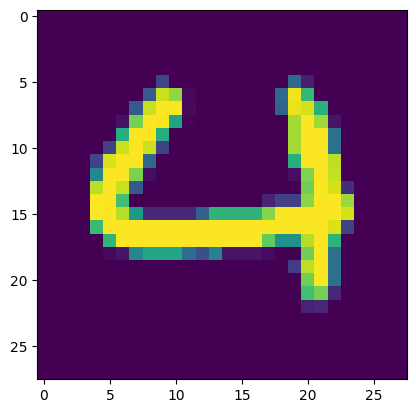

In [19]:
for idx, (batch, clean) in enumerate(train_loader):
    torch.cuda.empty_cache()
    
    img = batch.x[:,0][0:784].cpu()
    plt.imshow(img.view(28,28))

    break 

In [20]:
import scipy.sparse as sp

# Extract the edge indices and weights
edge_index = model.pc_conv1.edge_index_single_graph.cpu().numpy()

S2S_    = []
rest_   = []
for weights in model.pc_conv1.w_log:

    # Create a sparse matrix using the edge indices and weights
    W_sparse = sp.coo_matrix((weights.cpu(), (edge_index[0], edge_index[1])), shape=(model.pc_conv1.num_vertices, model.pc_conv1.num_vertices))

    # Convert to dense for detailed visualization (if the graph is not too large)
    W = W_sparse.toarray()

    S2S = W[0:784, 0:784]
    S2S_.append(S2S.max()) #, S2S.min())

    rest = W[784:, 784:]
    rest_.append(rest.max()) # rest.min())


print(np.array(S2S_).mean())
print(np.array(rest_).mean())

nan
nan


/tmp/ipykernel_194046/1642332991.py:23: RuntimeWarning: Mean of empty slice.
  print(np.array(S2S_).mean())
/home/erencan/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_194046/1642332991.py:24: RuntimeWarning: Mean of empty slice.
  print(np.array(rest_).mean())


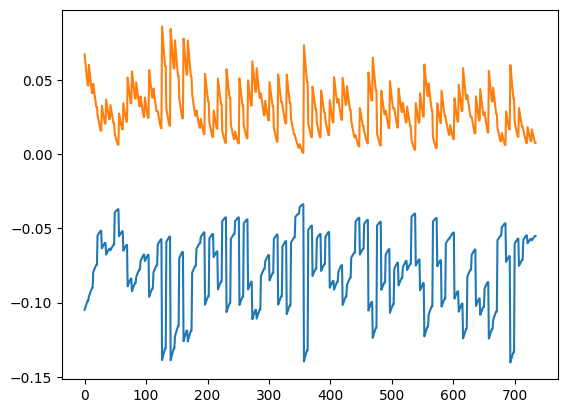

In [21]:
plt.plot(model.pc_conv1.energy_vals["mean_internal_energy_sign"][:])
plt.plot(model.pc_conv1.energy_vals["mean_sensory_energy_sign"][:])

In [22]:
model.pc_conv1.energy_vals["internal_energy"][:]

[8.245380401611328,
 8.024724006652832,
 7.819220542907715,
 7.630295753479004,
 7.454440116882324,
 7.291599273681641,
 7.291599273681641,
 6.892919540405273,
 6.707586288452148,
 6.537156105041504,
 6.376922130584717,
 6.230024814605713,
 6.091989517211914,
 6.091989517211914,
 4.724212646484375,
 4.597184181213379,
 4.479773998260498,
 4.369614601135254,
 4.267033100128174,
 4.171075344085693,
 4.171075344085693,
 2.2523179054260254,
 2.193655490875244,
 2.1388144493103027,
 2.0873327255249023,
 2.0392303466796875,
 1.993650197982788,
 1.9936504364013672,
 3.018009662628174,
 2.9395627975463867,
 2.8660364151000977,
 2.7973105907440186,
 2.7327747344970703,
 2.672334909439087,
 2.672335147857666,
 3.4369802474975586,
 3.3464670181274414,
 3.2618913650512695,
 3.1825218200683594,
 3.1087660789489746,
 3.039752960205078,
 3.039752960205078,
 3.1381967067718506,
 3.056821823120117,
 2.980682373046875,
 2.9096498489379883,
 2.8430161476135254,
 2.7804956436157227,
 2.7804956436157227,
 

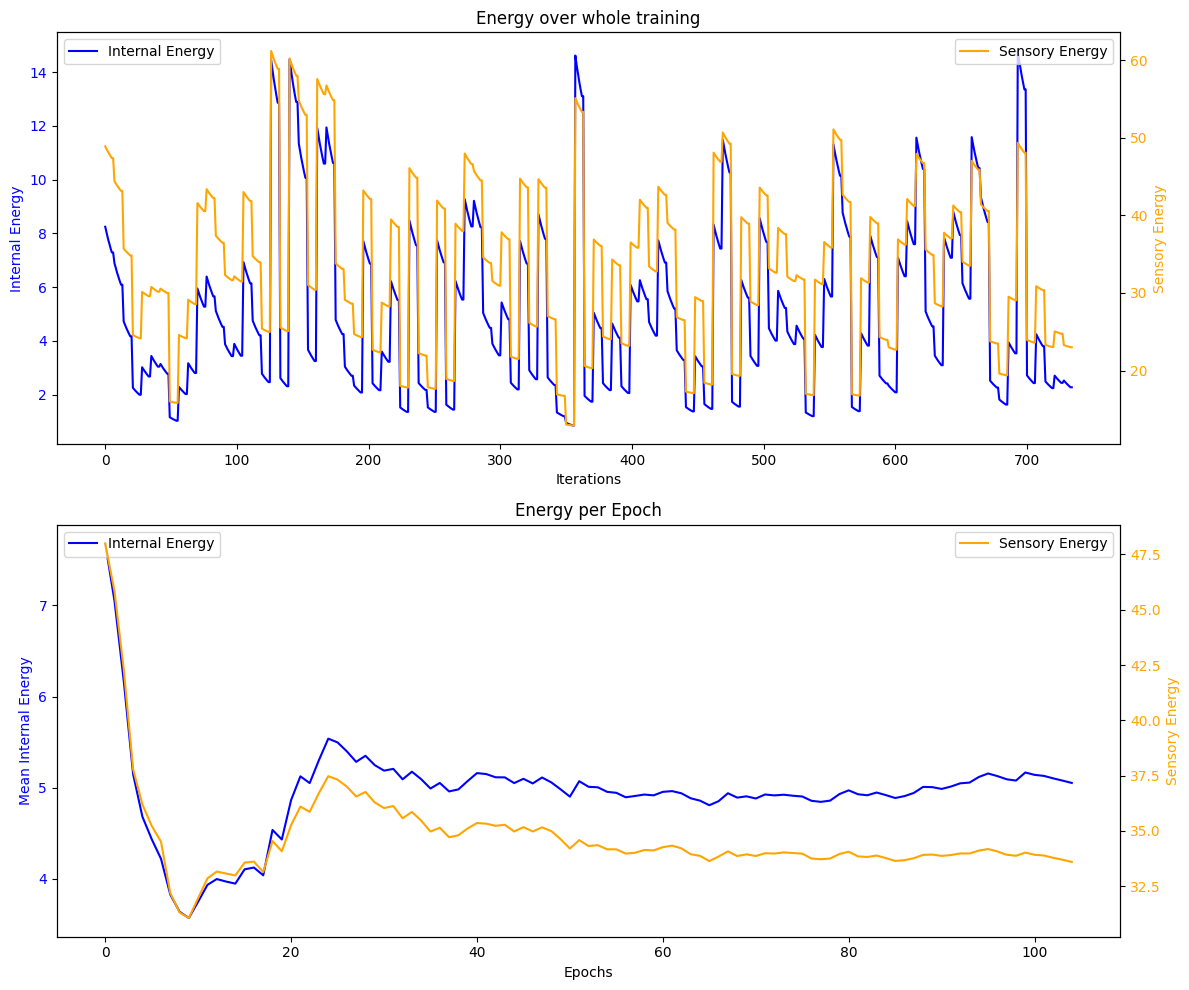

In [23]:
plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=None,
                                            epoch=epoch)

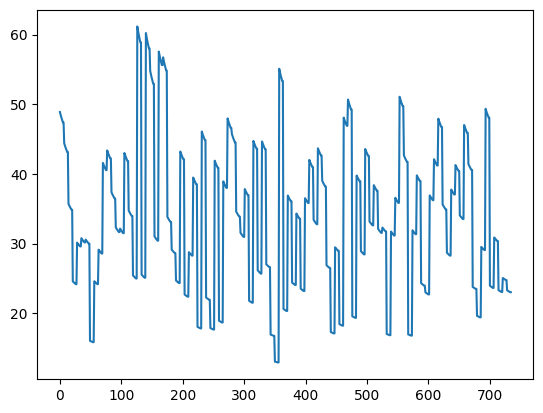

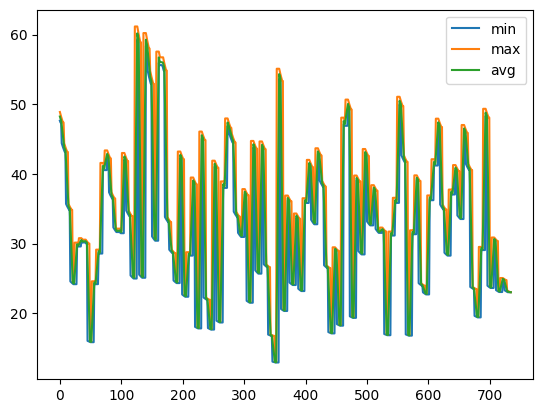

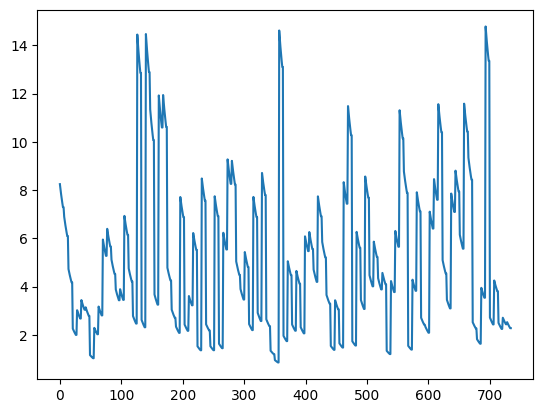

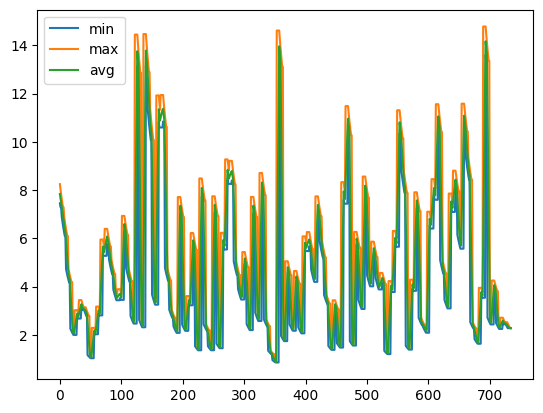

In [24]:



for t in [model.pc_conv1.energy_vals["sensory_energy"], model.pc_conv1.energy_vals["internal_energy"]]:

    plt.plot(t)
    plt.show()

    v_min = []
    v_max = []
    v_avg = []

    for w in range(0, len(t)):

        window = t[w:w+model.pc_conv1.T]
        w_min = min(window)
        w_max = max(window)
        w_avg = sum(window)/len(window)

        # w_mean = 

        v_min.append(w_min)
        v_max.append(w_max)
        v_avg.append(w_avg)

    plt.plot(v_min, label="min")
    plt.plot(v_max, label="max")
    plt.plot(v_avg, label="avg")

    plt.legend()
    plt.show()

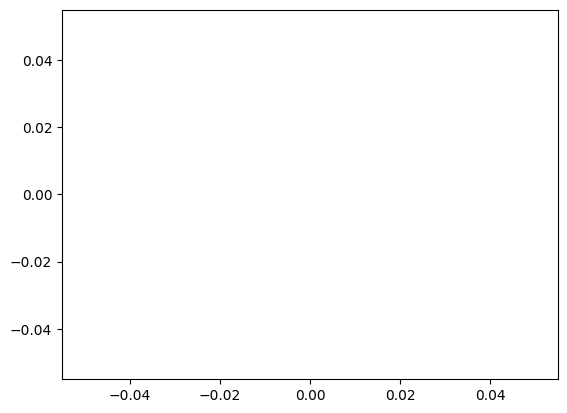

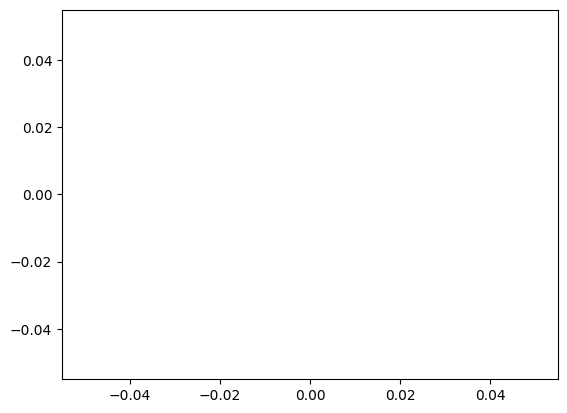

In [25]:
# weight_update_gain energy_drop

plt.plot(model.pc_conv1.energy_vals['energy_drop'])
plt.show()
plt.plot(model.pc_conv1.energy_vals['weight_update_gain'])

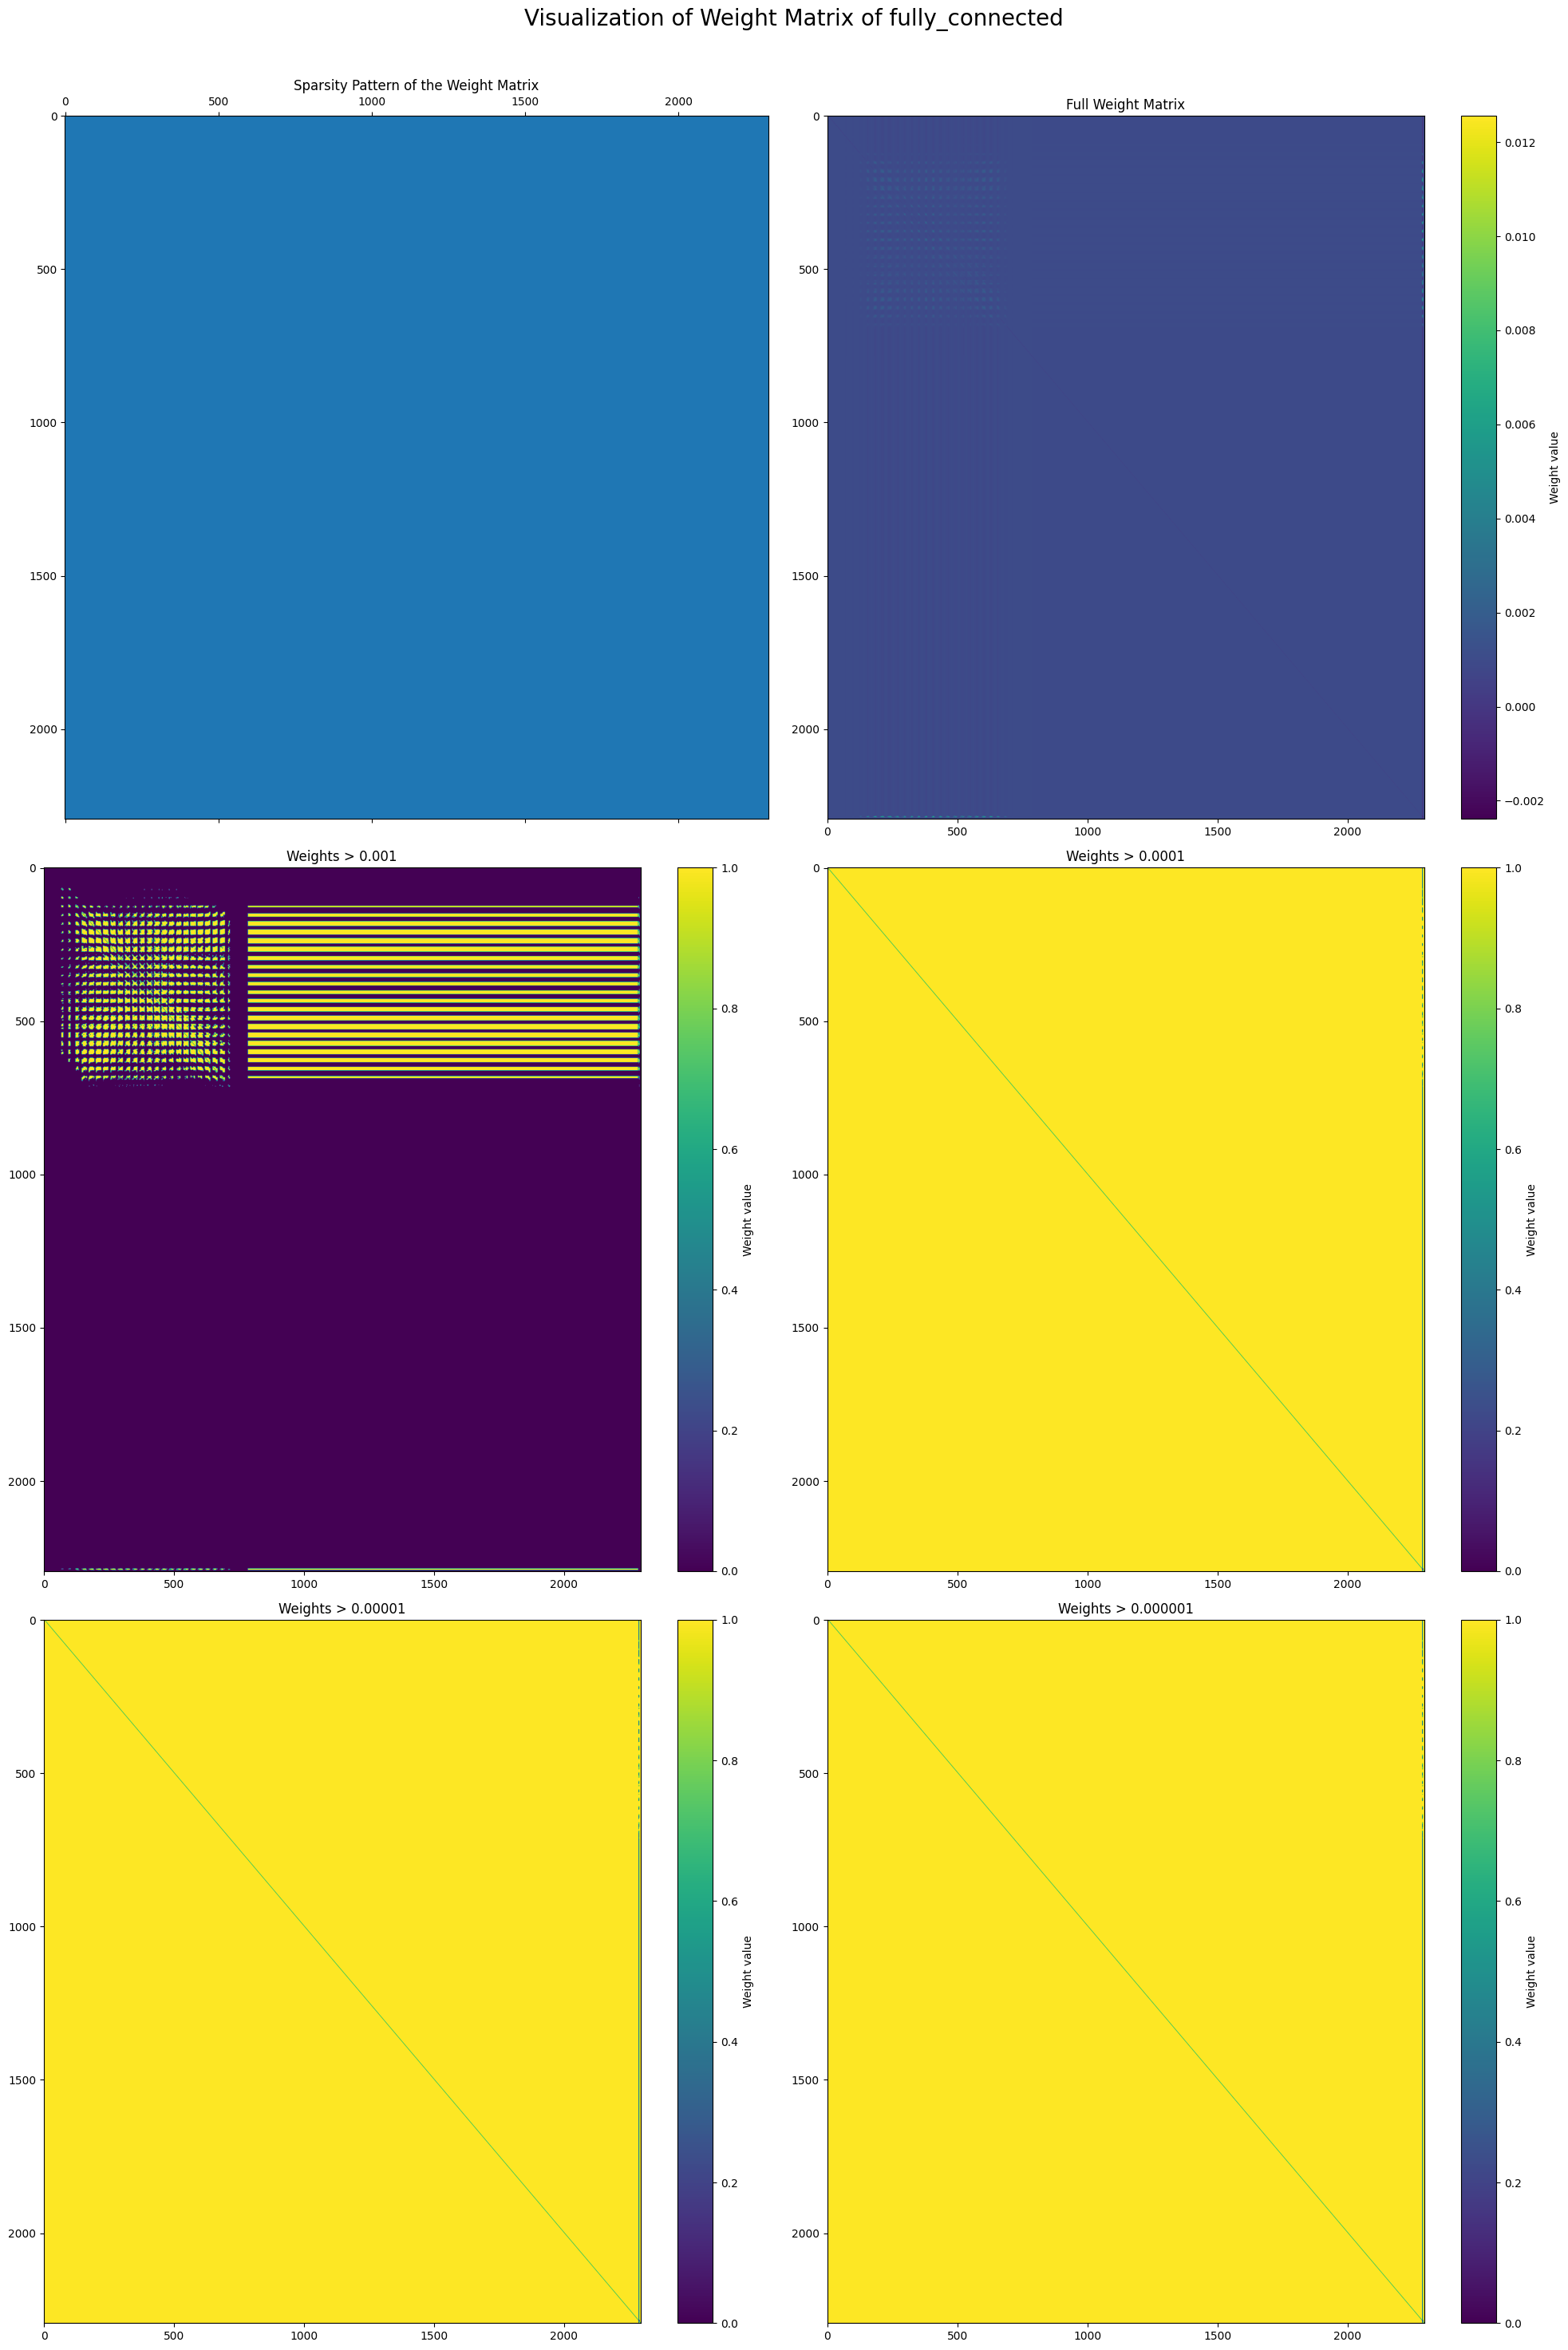

In [26]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
plot_model_weights(model, GRAPH_TYPE, model_dir=None)

In [27]:
# Save model weights 
######################################################################################################### 
####                                            Evaluation (setup)                                  #####
######################################################################################################### 
 
# device = torch.device('cpu')
from eval_tasks import classification, denoise, occlusion, generation #, reconstruction
model.pc_conv1.batchsize = 1


### Make dataloader for testing where we take all the digits of the number_list we trained on ###
dataset_params_testing = dataset_params.copy()

if "batch_size" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["batch_size"]

if "NUM_INTERNAL_NODES" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["NUM_INTERNAL_NODES"]

dataset_params_testing["edge_index"] = custom_dataset_train.edge_index

dataset_params_testing["mnist_dataset"] = mnist_testset
dataset_params_testing["N"] = "all"
dataset_params_testing["supervision_label_val"] = dataset_params["supervision_label_val"]



for key in dataset_params_testing:
    print(key, ":\t ", dataset_params_testing[key])


# CustomGraphDataset params
custom_dataset_test = CustomGraphDataset(graph_params, **dataset_params_testing, 
                                        indices=(num_vertices, sensory_indices, internal_indices, supervision_indices)
                                        )
# dataset_params_testing["batch_size"] = 2

test_loader = DataLoader(custom_dataset_test, batch_size=1, shuffle=True, generator=generator_seed)

mnist_dataset :	  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
supervised_learning :	  True
numbers_list :	  [1, 2, 3, 4, 5]
same_digit :	  False
add_noise :	  False
noise_intensity :	  0.0
N :	  all
edge_index :	  tensor([[   0,    0,    0,  ..., 2293, 2293, 2293],
        [   1,    2,    3,  ..., 2290, 2291, 2292]])
supervision_label_val :	  10
Supervised learning
Taking first n=all digits from each class
-----Done-----
2294
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110

In [28]:
# 
# plot_model_weights(model, model_dir=None)

In [29]:
# for idx, (noisy_batch, clean_image) in enumerate(test_loader, start=1):
#     noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape

#     torch.rand(noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape).shape
#     break

In [30]:
def get_clean_images_by_label(mnist_train, num_images=10):
    """
    Extract num_images clean images for each label (0-9) from mnist_train.
    Returns a dictionary with labels as keys and a list of clean images as values.
    """
    clean_images = {label: [] for label in range(10)}

    for label in range(10):
        # Filter the indices for the current label
        class_indices = [i for i, lbl in enumerate(mnist_train.targets) if lbl == label]
        
        # Get the first num_images clean images for the current label
        clean_images[label] = [mnist_train[i][0].squeeze().numpy() for i in class_indices[:num_images]]

    return clean_images

# Example usage:
clean_images = get_clean_images_by_label(mnist_trainset, num_images=10)



In [31]:
model.trace(values=True, errors=False)

vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task classification--------------
model.pc_conv1.values.shape torch.Size([2294, 1])
AAAAAAAAAAAA
model.pc_conv1.values.shape torch.Size([2294, 1])
CHECK 1  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
No vmin vmax
Done for idx 2942
tensor([4])
torch.Size([2294, 3, 1])
CHECK 2  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
CHECK 3  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], de

Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.8242759 -0.19996989
Denoised val 1.0 0.0
tensor([0.1072, 0.2473, 0.4405, 0.7847, 0.4236, 0.2366, 0.1072, 0.1072, 0.1072,
        0.1072], device='cuda:0')
tensor([0.1072, 0.2473, 0.4405, 0.7847, 0.4236, 0.2366, 0.1072, 0.1072, 0.1072,
        0.1072], device='cuda:0')
tensor([[0.1072],
        [0.2473],
        [0.4405],
        [0.7847],
        [0.4236],
        [0.2366],
        [0.1072],
        [0.1072],
        [0.1072],
        [0.1072]], device='cuda:0')
tensor([0.0832, 0.0957, 0.1160, 0.1637, 0.1141, 0.0947, 0.0832, 0.0832, 0.0832,
        0.0832], device='cuda:0')
tensor(3)
---------Done-----------------
TODO output y_pred and y_true to file 
[4] [3]
Classification Metrics:
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


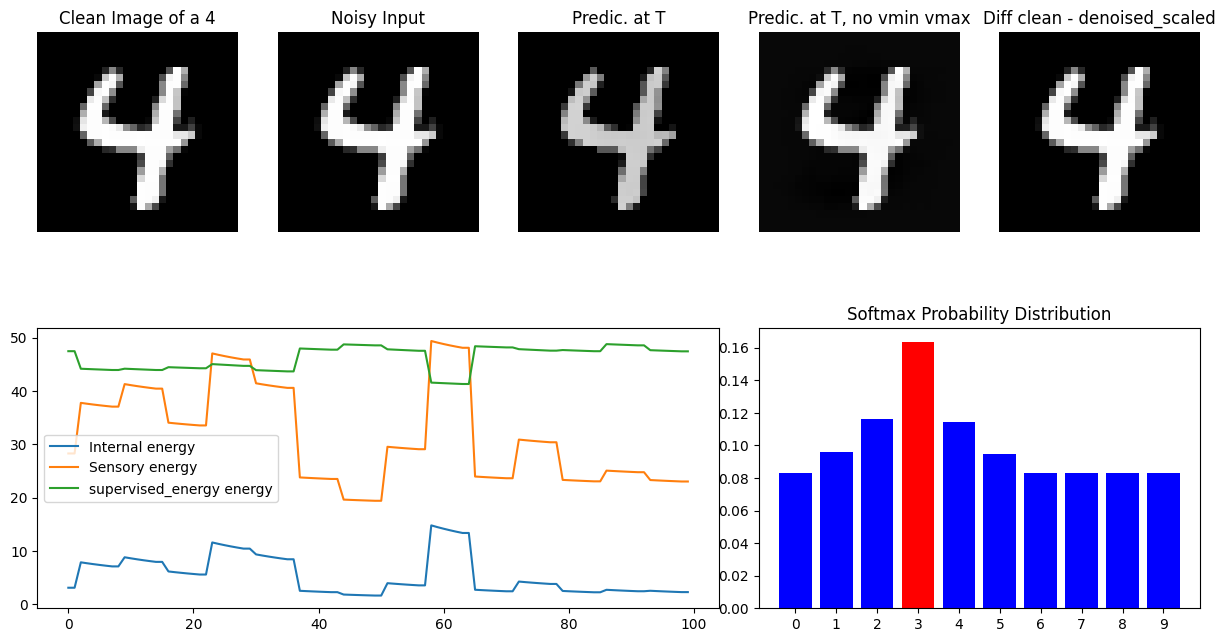

In [32]:
model.pc_conv1.trace_activity_values = True 

model.pc_conv1.batchsize = 1

test_params = {
    "model_dir": model_dir,
    "T":100,
    "supervised_learning":False, 
    "num_samples": 1,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

In [33]:
# model.enable_all_connections()

In [34]:
# # source_nodes = model.pc_conv1.edge_index[0]   # all i's 
# # target_nodes = model.pc_conv1.edge_index[1]   # all j's 

# # # Gather the corresponding errors and f_x values for each edge
# # # print("source_nodes shape", source_nodes.shape)
# # # print("errors shape", errors.shape)
# # # print("f_x shape", f_x.shape)
# # source_errors = model.pc_conv1.values[source_nodes].detach()    # get all e_i's 
# # target_fx = model.pc_conv1.values[target_nodes].detach()   

# # V = source_errors * target_fx

# V_p = V.reshape(model.pc_conv1.batchsize, model.pc_conv1.edge_index_single_graph.size(1)) 
# V_p.shape

In [35]:
# Example matrices
# matrix_list = [np.random.rand(5, 5) for _ in range(10)]  # Create 10 random 5x5 matrices

# matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["values"] ] 
matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["preds"] ] 

matrix_list = [torch.ger(i, i) for i in matrix_list]

# Create diagonal matrices from each tensor
# matrix_list = [torch.diag(i) for i in matrix_list]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure and axis
fig, ax = plt.subplots()

matrix_list_show = matrix_list[:20]

# Display the first matrix
im = ax.imshow(matrix_list_show[0], cmap='viridis')
cbar = plt.colorbar(im)  # Add the color bar

# Function to update the matrix in each frame
def update(frame):
    im.set_array(matrix_list_show[frame])  # Update the data for the new frame
    return [im]

# Prevent static display of imshow() after the animation
plt.close()

# Create the animation
ani = FuncAnimation(fig, update, frames=len(matrix_list_show), blit=True, interval=500)

# Display the animation in the notebook
HTML(ani.to_jshtml())


KeyboardInterrupt



[tensor([[6.7524e-06, 6.7524e-06, 6.7524e-06,  ..., 5.8585e-05, 5.8585e-05,
          5.8585e-05],
         [6.7524e-06, 6.7524e-06, 6.7524e-06,  ..., 5.8585e-05, 5.8585e-05,
          5.8585e-05],
         [6.7524e-06, 6.7524e-06, 6.7524e-06,  ..., 5.8585e-05, 5.8585e-05,
          5.8585e-05],
         ...,
         [5.8585e-05, 5.8585e-05, 5.8585e-05,  ..., 5.0829e-04, 5.0829e-04,
          5.0829e-04],
         [5.8585e-05, 5.8585e-05, 5.8585e-05,  ..., 5.0829e-04, 5.0829e-04,
          5.0829e-04],
         [5.8585e-05, 5.8585e-05, 5.8585e-05,  ..., 5.0829e-04, 5.0829e-04,
          5.0829e-04]]),
 tensor([[6.7524e-06, 6.7524e-06, 6.7524e-06,  ..., 5.8585e-05, 5.8585e-05,
          5.8585e-05],
         [6.7524e-06, 6.7524e-06, 6.7524e-06,  ..., 5.8585e-05, 5.8585e-05,
          5.8585e-05],
         [6.7524e-06, 6.7524e-06, 6.7524e-06,  ..., 5.8585e-05, 5.8585e-05,
          5.8585e-05],
         ...,
         [5.8585e-05, 5.8585e-05, 5.8585e-05,  ..., 5.0829e-04, 5.0829e-04,
   

vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task classification--------------
model.pc_conv1.values.shape torch.Size([2294, 1])
AAAAAAAAAAAA
model.pc_conv1.values.shape torch.Size([2294, 1])
CHECK 1  tensor([[0.1168],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.1432],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.2094]], device='cuda:0')
No vmin vmax
Done for idx 538
tensor([5])
torch.Size([2294, 3, 1])
CHECK 2  tensor([[0.1168],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.1432],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.2094]], device='cuda:0')
CHECK 3  tensor([[0.1168],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.1432],
        [0.1168],
        [0.1168],
        [0.1168],
        [0.2094]], device='cuda:0')
labels model tensor([[0.],
        [0

Final internal energy (t=T): 2.7029004096984863
Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.81895 -0.18138325
Denoised val 1.0 0.0
tensor([0.1193, 0.1193, 0.1193, 0.1193, 0.1193, 0.1884, 0.1193, 0.1193, 0.1193,
        0.1184], device='cuda:0')
tensor([0.1193, 0.1193, 0.1193, 0.1193, 0.1193, 0.1884, 0.1193, 0.1193, 0.1193,
        0.1184], device='cuda:0')
tensor([[0.1193],
        [0.1193],
        [0.1193],
        [0.1193],
        [0.1193],
        [0.1884],
        [0.1193],
        [0.1193],
        [0.1193],
        [0.1184]], device='cuda:0')
tensor([0.0993, 0.0993, 0.0993, 0.0993, 0.0993, 0.1064, 0.0993, 0.0993, 0.0993,
        0.0992], device='cuda:0')
tensor(5)


KeyError: 'num_wandb_img_log'

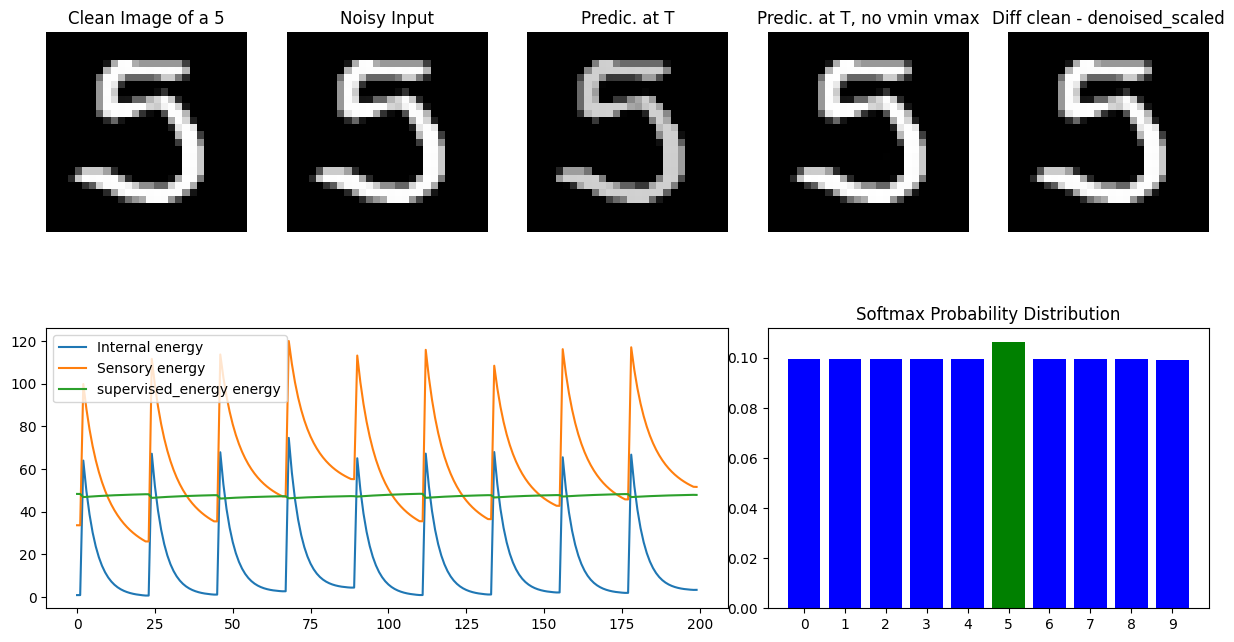

In [29]:

model.pc_conv1.batchsize = 1

test_params = {
    "model_dir": model_dir,
    "T":200,
    "supervised_learning":False, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

In [29]:


model.pc_conv1.batchsize = 1

######################################################################################################### 
####                                            Evaluation (tasks)                                  #####
######################################################################################################### 
 
test_params = {
    "model_dir": model_dir,
    "T": 100,
    "supervised_learning":True, 
    "num_samples": 1,
    "add_sens_noise": False,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1 
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_occ = occlusion(test_loader, model, test_params)


vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task reconstruction--------------
-------------Restarting activity (pred/errors/values)--------------
Done for idx 1208
idx 1
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS reconstruction
Pass
Initial internal energy (t=0): 64.2430419921875


Final internal energy (t=T): 0.51778244972229
Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.88111067 -0.115826294
Denoised val 0.99607843 0.0
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


In [52]:


######################################################################################################### 

######################################################################################################### 

test_params["add_sens_noise"] = True
MSE_values_occ_noise = occlusion(test_loader, model, test_params)

test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 6,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_denoise_sup = denoise(test_loader, model, test_params)

test_params["supervised_learning"] = False
MSE_values_denoise = denoise(test_loader, model, test_params)
                            
# MSE_values = denoise(test_loader, model, supervised_learning=True)
# print("MSE_values", MSE_values)
######################################################################################################### 



# # MSE_values = denoise(test_loader, model, supervised_learning=True)
# # print("MSE_values", MSE_values)


# print("accuracy_mean", accuracy_mean)

# print("model_dir", model_dir)

# # write a text file with these 


# # Open the file in write mode
# with open(model_dir + "eval/eval_scores.txt", 'w') as file:
#     # Write each list to the file

#     file.write("MSE_values_denoise_sup:\n")
#     file.write(", ".join(map(str, MSE_values_denoise_sup)) + "\n\n")

#     file.write("MSE_values_denoise:\n")
#     file.write(", ".join(map(str, MSE_values_denoise)) + "\n\n")
    
#     file.write("MSE_values_occ_noise:\n")
#     file.write(", ".join(map(str, MSE_values_occ_noise)) + "\n\n")
    
#     file.write("MSE_values_occ:\n")
#     file.write(", ".join(map(str, MSE_values_occ)) + "\n\n")

#     file.write("accuracy_mean:\n")
#     file.write("y_true: " + ", ".join(map(str, y_true)) + "\n")
#     file.write("y_pred: " + ", ".join(map(str, y_pred)) + "\n")
    
#     file.write(str(accuracy_mean) + "\n\n")


# from datetime import datetime
# # Get the current date and time
# current_datetime = datetime.now()
# # Print the current date and time
# print("Current date and time:", current_datetime)



# wandb.log({"accuracy_mean": accuracy_mean})
# # wandb.log({"energy_sensory": energy["sensory_energy"]})






# wandb.finish()

vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task reconstruction--------------
-------------Restarting activity (pred/errors/values)--------------
Done for idx 1464
idx 1
labels model tensor([[0.6907],
        [0.4715],
        [0.7586],
        [0.3157],
        [0.0587],
        [0.5891],
        [0.3731],
        [0.3900],
        [0.6559],
        [0.1462]], device='cuda:0')
Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS reconstruction
Pass
Initial internal energy (t=0): 84.97221374511719


Final internal energy (t=T): 0.9431438446044922
Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.8404234 -0.15650222
Denoised val 0.99607843 0.0
tensor([[0.6907],
        [0.4715],
        [0.7586],
        [0.3157],
        [0.0587],
        [0.5891],
        [0.3731],
        [0.3900],
        [0.6559],
        [0.1462]], device='cuda:0')
vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task reconstruction--------------
-------------Restarting activity (pred/errors/values)--------------
vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task reconstruction--------------
Done for idx 1017
labels model tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.]], device='cuda:0')
Random init values of all int

KeyboardInterrupt: 

In [15]:
# model.Disable_connection(from_indices=sensory_indices, 
#                          to_indices=supervision_indices)

In [ ]:
# model.enable_all_connections()

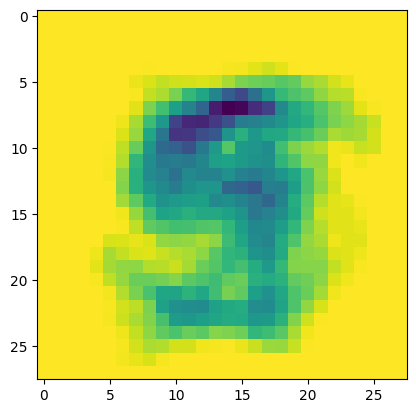

In [33]:
plt.imshow(model.pc_conv1.trace['preds'][0][0:784].view(28,28).cpu())
plt.show()

-------------Restarting activity (pred/errors/values)--------------
-------------Restarting activity (pred/errors/values)--------------
vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task generation--------------
model.pc_conv1.values.shape torch.Size([2294, 1])
-------------Restarting activity (pred/errors/values)--------------
No vmin vmax
Done for idx 1
tensor([5])
torch.Size([2294, 3, 1])
omitting setting sensory nodes


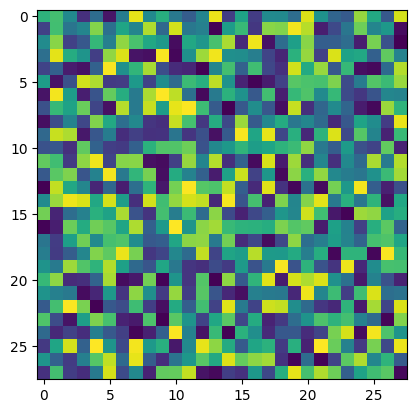

labels before torch.Size([10]) tensor([0.0000, 0.0000, 0.2302, 0.0000, 0.0000, 0.4717, 0.0000, 0.0000, 0.1031,
        0.0000], device='cuda:0')
labels after tensor([0.0000, 0.0000, 0.2302, 0.0000, 0.0000, 0.4717, 0.0000, 0.0000, 0.1031,
        0.0000], device='cuda:0')
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
labels model tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
aaa testing
CHECK tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS generation
Pass
Aaaa torch.Size([2294, 3, 1])


Inference completed.
QUery by condition or query by init
CHECK tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
Predic. at T, no vmin vmax -0.026690573 -0.054456532
Denoised val 0.23386943 0.16189618
generation_task_5.png
CHECK tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
ssim_values [-0.010478947334369637]
mse_values [0.13093235]
ssim_values [-0.010478947334369637, -0.004727777969289363]
mse_values [0.13093235, 0.06613367]
ssim_values [-0.010478947334369637, -0.004727777969289363, -0.0067835386916090664]
mse_values [0.13093235, 0.06613367, 0.07449494]
ssim_values [-0.010478947334369637, -0.004727777969289363, -0.0067835386916090664, -0.0014390868012819098]
mse_values [0.13093235, 0.06613367, 0.07449494, 0.111388944]
ssim_values [-0.010478947334369

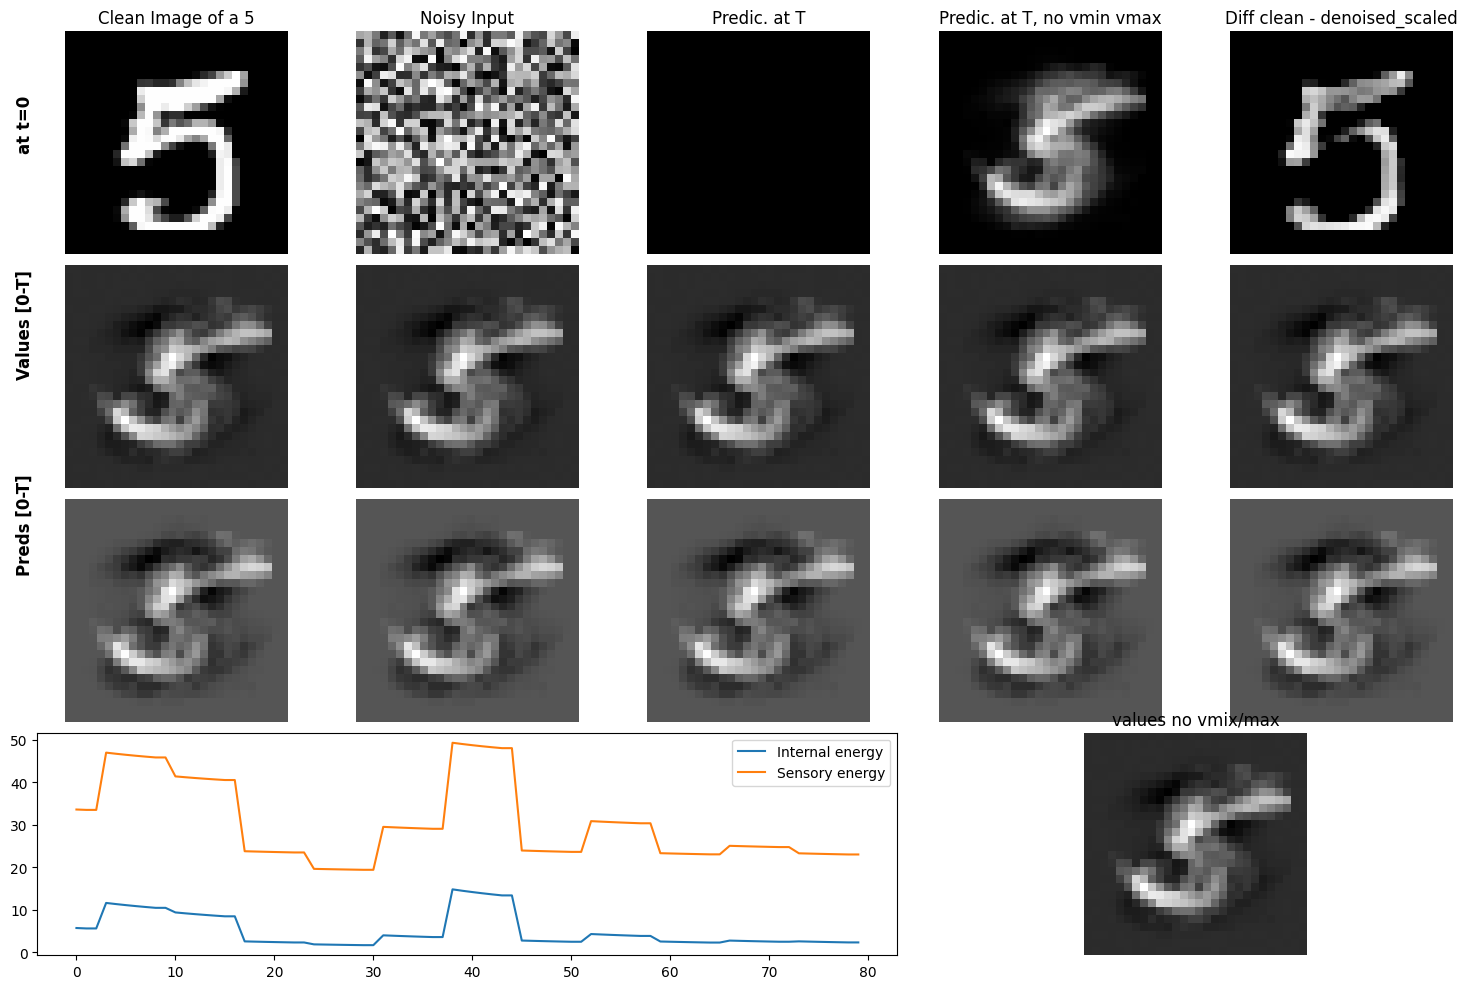

In [43]:
test_params = {
    "model_dir": model_dir,
    "T": 80,
    "supervised_learning":True, 
    "num_samples": 1,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
model.pc_conv1.trace_activity_values = True 
model.pc_conv1.trace_activity_preds = True 


model.pc_conv1.restart_activity()

avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max = generation(test_loader, model, test_params, clean_images, verbose=1)
                            

NameError: name 'noisy_batch' is not defined

In [40]:
len(model.pc_conv1.trace["values"])

81

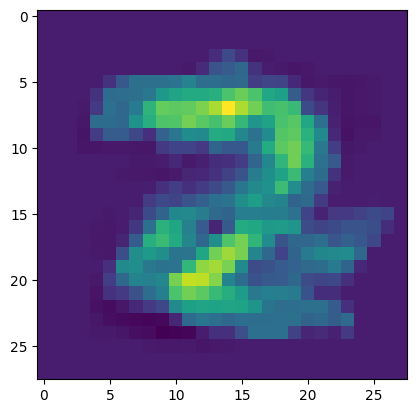

In [24]:
# len(model.pc_conv1.trace["values"])
plt.imshow(model.pc_conv1.trace["values"][0][0:784].view(28,28).cpu())

In [50]:
import math 
# Define the range for logarithmic initialization
log_min = 1e-4  # Minimum value in the range
log_max = 1e-1  # Maximum value in the range
# num_weights = self.edge_index_single_graph.size(1)  # Number of weights to initialize
num_weights = 100  # Number of weights to initialize

# Initialize weights logarithmically between log_min and log_max
log_weights = torch.logspace(math.log10(log_min), math.log10(log_max), steps=num_weights)

# # Simulate a lognormal distribution for synaptic weights based on the description
# mu, sigma = 0, 1  # Mean and standard deviation for lognormal distribution
# weights = np.random.lognormal(mu, sigma, 1000)

# Using batch size, we want the same edge weights at each subgraph of the batch
# weights = torch.nn.Parameter(log_weights)
weights = log_weights

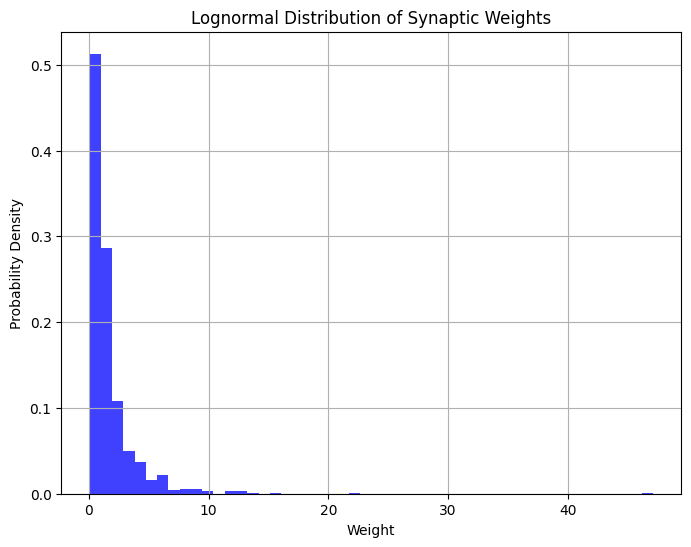

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the histogram of the weights
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=50, density=True, alpha=0.75, color='b')
plt.title('Lognormal Distribution of Synaptic Weights')
plt.xlabel('Weight')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()